# A short introduction to Gaia Archive: ADQL & TAP by examples

## Morgan Fouesneau

# Notebook configuration

Below we will do some plotting. The following commands are making things a bit nicer. (all personal libraries are included with this notebook).

In [1]:
# Loading configuration
# Don't forget that mac has this annoying configuration that leads
# to limited number of figures/files
# ulimit -n 4096    <---- osx limits to 256
import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore")

%pylab inline
%config InlineBackend.figure_format='retina'

import pylab as plt
import numpy as np
import figrc, setup_mpl
setup_mpl.theme()
setup_mpl.solarized_colors()

Populating the interactive namespace from numpy and matplotlib


# Interogating Gaia Archive

Gaia Archive website: https://gea.esac.esa.int/archive/

The entry point is a TAP (Table Access Protocol) server.

TAP provides two operation modes, **Synchronous** and **Asynchronous**.

* **Synchronous**: the response to the request will be generated as soon as the request received by the server.

* **Asynchronous**: the server will start a job that will execute the request.
  The first response to the request is the required information (a link) to obtain the job status. 
  Once the job is finished, the results can be retrieved.
  

## Gaia Archive TAP service
Gaia Archive TAP server provides two access modes: *public* and *authenticated*

* **Public**: this is the standard TAP access. 
  A user can execute ADQL queries and upload tables to be used in a query 'on-the-fly' (these tables will be removed once the query is executed). 
  The results are available to any other user and they will remain in the server for a limited space of time.
  
* **Authenticated**: some functionalities are restricted to authenticated users only.
  The results are saved in a private user space and they will remain in the server for ever (they can be removed by the user). ADQL queries and results are saved in a user private area.

* *Cross-match operations*: a catalogue cross-match operation can be executed. 
  Cross-match operations results are saved in a user private area.

## What is ADQL?

ADQL = Astronomical Data Query Language

ADQL has been developed based on `SQL92` and supports a subset of the SQL grammar with extensions to support generic and astronomy specific operations.

In other words, ADQL is a SQL-like searching language improved with geometrical functions.

for more information see the IVOA documentation http://www.ivoa.net/documents/latest/ADQL.html

* examples of SQL minimal queries

```mysql
SELECT *
FROM "gaiadr1.tgas_source"
```

```mysql
SELECT top 1000 ra, dec, phot_g_mean_mag AS mag  
FROM "gaiadr1.gaia_source"
ORDER BY mag
```

### Basic Keywords

* `TOP` limits the number of records to display
* `ORDER BY` sorts records in ascending (`ASC`, default) or descending (`DESC`)
* `WHERE` filters records according to logical expressions
* `IN`, `NOT IN` operator that can determine whether a value is (not) within a given set
* `BETWEEN x AND y` operator can determine whether a value is within a given interval
* `LIKE` operator allows for a partial comparison, It uses wild cards `%` and `_` ('percent' and 'underscore'). The wild card `%` replaces any string of characters, including the empty string. The underscore replaces exactly one character.
* `GROUP BY` groups records by identical values (or set of values)
* `=` or `>` or `<` or `>=` or `<=` or `<>`, different operators of logical comparisons
* `+`, `-`, `*`, `/`, compute columns using mathematical operations
* `POWER(column_name, n)` returns values raised to the power n. n must be a integer positive or negative.
* `SQRT(column_name)` returns the square root of values.
* `CEILING(column_name)` rounds up to the nearest integer value.
* `FLOOR(column name)` rounds down to the next least integer value.
* `ABS(column_name)` returns the absolute value.
* `AVG (column_name)` this function returns the average value in a column for a group of data lines
* `COUNT (column_name)` this function returns a count of rows from a reference column values if it is not NULL.
* `SUM(column_name)` this function returns the sum of values in a column for a group of data lines. 
* `MAX`, `MIN`, return the largest or smallest value of a column for a group of data lines.
* `COS`, `SIN`, `TAN`, `ACOS`, `ASIN`, `ATAN` of  an angle in radian compute the trigonometric transformation

### Geometries and geometrical functions

ADQL provides a set of 2D-functions and geometries or *regions*

A region is always attached to a coordinate System: `FK4`, `FK5`, `ICRS`, `GALACTIC`.
The coordinates expressed *in degree*, can be constant or the result of a mathematical expression.

* `POINT('coordinate system', right ascension, declination)` expresses a point source on the sky

* `CIRCLE('coordinate system',right ascension center, declination center, radius in degrees)` expresses a circular region on the sky (a cone in space)

* `BOX('coordinate system', right ascension center, declination center, width, height)` defines a centered box

* `POLYGON('coordinate system', coordinate point 1, coordinate point 2, coordinate point 3...)` expresses a region on the sky with sides denoted by great circles passing through specified list of `POINT` objects.

* `DISTANCE(point1, point2)` computes distance between two points.

* `CONTAINS(region1, region2)` returns a boolean value : `true` if `region2` contains `region1`, `false` otherwise.

* `INTERSECTS(region1, region2)` returns a boolean value : `true` if `region2` intersect `region1`, `false` otherwise.

# Current python package

**Some common code to send ADQL Queries to TAP services and notebook polishing**

* `GaiaArchive` is a shortcut from `TAP_service` to the interface with the Gaia Archive
* `TAPVizieR`   is a shortcut from `TAP_service` to the interface with TAP service of VizieR (CDS).
* `resolve`     interfaces CDS/Sesame name resolver to get positions of known objects by their names.
* `QueryStr`    is a polished string that parses an SQL syntax to make it look nicer (for notebook and console)
* `timeit`      a context manager/decorator that reports execution time (for notebook and console)

In [2]:
from tap import (GaiaArchive, TAPVizieR, resolve, QueryStr, timeit)

## Quick Start: How to query TAP with this package?

Let's start by checking that we can access the data by requesting the first 5 sources in TGAS.

**Synchronous mode**

Get the service and submit the query. The result will be downloaded automatically.

In [4]:
gaia = GaiaArchive()

select a small number of rows in the gaia DR1 data table. 

**Note**: we use `QueryStr` only for giving an easier reading. A string would work as well.

In [5]:
adql = QueryStr("""
select top 5 * from gaiadr1.gaia_source
""")

*ADQL query*
```mysql

SELECT top 5 * FROM gaiadr1.gaia_source

```

Now we run the query. 

**Note**: we use `timeit` in this notebook to indicate how long the operation  `gaia.query` took.

In [6]:
timeit(gaia.query)(adql)

*Execution time*: 606 ms

solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_good_obs_ac,astrometric_n_bad_obs_al,astrometric_n_bad_obs_ac,astrometric_delta_q,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_primary_flag,astrometric_relegation_factor,astrometric_weight_al,astrometric_weight_ac,astrometric_priors_used,matched_observations,duplicated_source,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_variable_flag,l,b,ecl_lon,ecl_lat
,,,Time[Julian Years],Angle[deg],Angle[mas],Angle[deg],Angle[mas],Angle[mas],Angle[mas],Angular Velocity[mas/year],Angular Velocity[mas/year],Angular Velocity[mas/year],Angular Velocity[mas/year],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],,,,,,,,Angle[mas],,,,Angle[mas^-2],Angle[mas^-2],,,,,,,,Angle[deg],Angle[deg],Angle[deg],Angle[deg],,Flux[e-/s],Flux[e-/s],Magnitude[mag],Dimensionless[see description],Angle[deg],Angle[deg],Angle[deg],Angle[deg]
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,float32,float64,float64,bool,float32,float32,float32,int32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,object,float64,float64,float64,float64
1635378410781933568,4088615248674468480,361437867,2015.0,285.91181521496105,9.7509541542694027,-16.279712060651672,11.917370199056696,--,--,--,--,--,--,0.99989998,--,--,--,--,--,--,--,--,--,61,0,61,0,0,0,--,0.52760368339673314,15.433735089286511,False,1.7672774,2.6038001,--,2,9,False,0.30018896,0.69825655,0.3696852,0.91914082,-72.13047,-44.042316,-36.721554,42.793583,61,9191.0003423573417,9.2277338165121243,15.616363108138401,NOT_AVAILABLE,19.655082764709014,-9.9805895755391063,285.35341589344137,6.3155037002071808
1635378410781933568,4088666032361491584,933318629,2015.0,285.02922731133623,3.4138826245281324,-16.222160209509276,3.198286161705453,--,--,--,--,--,--,0.25130001,--,--,--,--,--,--,--,--,--,44,0,44,0,0,0,--,0.6391602497186295,1.5843669543589385,False,1.3652215,0.64151943,--,2,6,False,0.77107835,0.61997402,0.93719929,0.91208309,-56.220982,-36.867126,-38.230732,-43.96833,42,1235.6032820581979,4.0751150584085662,17.795072430787823,NOT_AVAILABLE,19.336084623850226,-9.1917083944921423,284.51185238823103,6.4631920195092905
1635378410781933568,4088613431903695872,125924794,2015.0,285.88918929736326,5.7435387113667895,-16.382069945375665,6.8085167262979178,--,--,--,--,--,--,0.99024999,--,--,--,--,--,--,--,--,--,43,0,42,0,1,0,--,1.0753230184252538,0.4533348505713104,False,4.2586412,0.082859688,--,2,9,False,0.39920869,0.57381517,0.45355245,0.96555835,-81.849922,-45.94566,-40.509377,40.369743,42,275.26650382924527,2.5697553781231575,19.425386646573937,NOT_AVAILABLE,19.551790440146672,-10.005095738600806,285.3204147767525,6.2161432838578357
1635378410781933568,4088839965670563712,230847729,2015.0,286.94890773554778,1.3097898423715901,-15.90479382159516,1.4938311169461376,--,--,--,--,--,--,0.98449999,--,--,--,--,--,--,--,--,--,79,0,79,0,0,0,--,0.0,0.0,False,1.0,0.70771897,--,2,10,False,0.34878218,0.54846704,0.46166831,0.91311711,-83.054253,-41.611794,-

**Asynchronous mode**

From the same service, use the `query_async` method. The job will be submitted and accessible later.

*Why this mode would be prefered?* Some services (incl. the Gaia Archive) limit strongly the queries using the synchronous mode. For example the Gaia Archive limits to 1 minute jobs, mostly to avoid comminucation issues.
Read the documentation of the service you want to use to decide.

Below I use the `async` mode to redo the exact same query as before.

In [7]:
q = gaia.query_async(adql, silent=True)
q   # pretty print display

*ADQL Query*
```mysql

SELECT top 5 * FROM gaiadr1.gaia_source

```
* *Status*:   `303`, Reason `303`
* *Location*: http://gea.esac.esa.int/tap-server/tap/async/1479126840703O
* *Job id*:   `1479126840703O`

                            

One can interogate the service to know if the task is complete.

In [8]:
q.status

'EXECUTING'

Finally we can download the result when available. 

(The provided python interface has an option to wait or not for completion; keyword `wait=True`, default behavior)

In [9]:
q.get()

solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_good_obs_ac,astrometric_n_bad_obs_al,astrometric_n_bad_obs_ac,astrometric_delta_q,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_primary_flag,astrometric_relegation_factor,astrometric_weight_al,astrometric_weight_ac,astrometric_priors_used,matched_observations,duplicated_source,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_variable_flag,l,b,ecl_lon,ecl_lat
,,,Time[Julian Years],Angle[deg],Angle[mas],Angle[deg],Angle[mas],Angle[mas],Angle[mas],Angular Velocity[mas/year],Angular Velocity[mas/year],Angular Velocity[mas/year],Angular Velocity[mas/year],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],,,,,,,,Angle[mas],,,,Angle[mas^-2],Angle[mas^-2],,,,,,,,Angle[deg],Angle[deg],Angle[deg],Angle[deg],,Flux[e-/s],Flux[e-/s],Magnitude[mag],Dimensionless[see description],Angle[deg],Angle[deg],Angle[deg],Angle[deg]
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,float32,float64,float64,bool,float32,float32,float32,int32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,object,float64,float64,float64,float64
1635378410781933568,4088615248674468480,361437867,2015.0,285.91181521496105,9.7509541542694027,-16.279712060651672,11.917370199056696,--,--,--,--,--,--,0.99989998,--,--,--,--,--,--,--,--,--,61,0,61,0,0,0,--,0.52760368339673314,15.433735089286511,False,1.7672774,2.6038001,--,2,9,False,0.30018896,0.69825655,0.3696852,0.91914082,-72.13047,-44.042316,-36.721554,42.793583,61,9191.0003423573417,9.2277338165121243,15.616363108138401,NOT_AVAILABLE,19.655082764709014,-9.9805895755391063,285.35341589344137,6.3155037002071808
1635378410781933568,4088666032361491584,933318629,2015.0,285.02922731133623,3.4138826245281324,-16.222160209509276,3.198286161705453,--,--,--,--,--,--,0.25130001,--,--,--,--,--,--,--,--,--,44,0,44,0,0,0,--,0.6391602497186295,1.5843669543589385,False,1.3652215,0.64151943,--,2,6,False,0.77107835,0.61997402,0.93719929,0.91208309,-56.220982,-36.867126,-38.230732,-43.96833,42,1235.6032820581979,4.0751150584085662,17.795072430787823,NOT_AVAILABLE,19.336084623850226,-9.1917083944921423,284.51185238823103,6.4631920195092905
1635378410781933568,4088613431903695872,125924794,2015.0,285.88918929736326,5.7435387113667895,-16.382069945375665,6.8085167262979178,--,--,--,--,--,--,0.99024999,--,--,--,--,--,--,--,--,--,43,0,42,0,1,0,--,1.0753230184252538,0.4533348505713104,False,4.2586412,0.082859688,--,2,9,False,0.39920869,0.57381517,0.45355245,0.96555835,-81.849922,-45.94566,-40.509377,40.369743,42,275.26650382924527,2.5697553781231575,19.425386646573937,NOT_AVAILABLE,19.551790440146672,-10.005095738600806,285.3204147767525,6.2161432838578357
1635378410781933568,4088839965670563712,230847729,2015.0,286.94890773554778,1.3097898423715901,-15.90479382159516,1.4938311169461376,--,--,--,--,--,--,0.98449999,--,--,--,--,--,--,--,--,--,79,0,79,0,0,0,--,0.0,0.0,False,1.0,0.70771897,--,2,10,False,0.34878218,0.54846704,0.46166831,0.91311711,-83.054253,-41.611794,-

Luckily, we obtain the same result as before.

**Authenticate with your account**

The current python package also allows you to authenticate. This is mostly relevant when using `async` queries, or user tables.

```python
gaia.login("my_user_name")
```
The above will prompt for a password.

Note that the password can also be provided as argument if you need to script some queries. It will not be stored, only the relevant `cookie` will be conserved until the end of the session.

**Callback previous jobs**

In some cases (mostly when authenticated) you might want to download a previous job. This python package allows you to do so using `recall_query`, which returns an asynchronous result.

In [ ]:
qprime = gaia.recall_query(q.jobid)
qprime.get()

# Make the luminosity function of the TGAS stars

In this example, we want to make the luminosity function of TGAS stars. Of course we could download all stars and do it on our computer but one can do it on the server side and only download the computed *histogram*.

*hint*: Building a luminosity function means that we want to `select` all stars in TGAS (with magnitude) and `count` them after `grouping` them per bin of magnitudes. Additionally one will want to `sort` the bins for plotting them in order.

In [10]:
adql = QueryStr("""
select 
    count(*) as n, 
    round(phot_g_mean_mag, 1) as val
from 
    gaiadr1.tgas_source 
group by val
order by val
""")

*ADQL query*
```mysql

SELECT
    count(*) AS n,
    round(phot_g_mean_mag, 1) AS val
FROM
    gaiadr1.tgas_source
GROUP BY val
ORDER BY val

```

Run the query

In [11]:
data_tgas = timeit(gaia.query)(adql)

*Execution time*: 33.2 s

**Note**:
Sometimes the Gaia Archive crashes... BUG! This is needed feedback to the service.

You can bypass the issue by using `async` queries or re-run until you give up...

In [12]:
data_tgas = gaia.query_async(adql).get()

Query Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1479126879844O
Job id: 1479126879844O


Plot the histogram data.

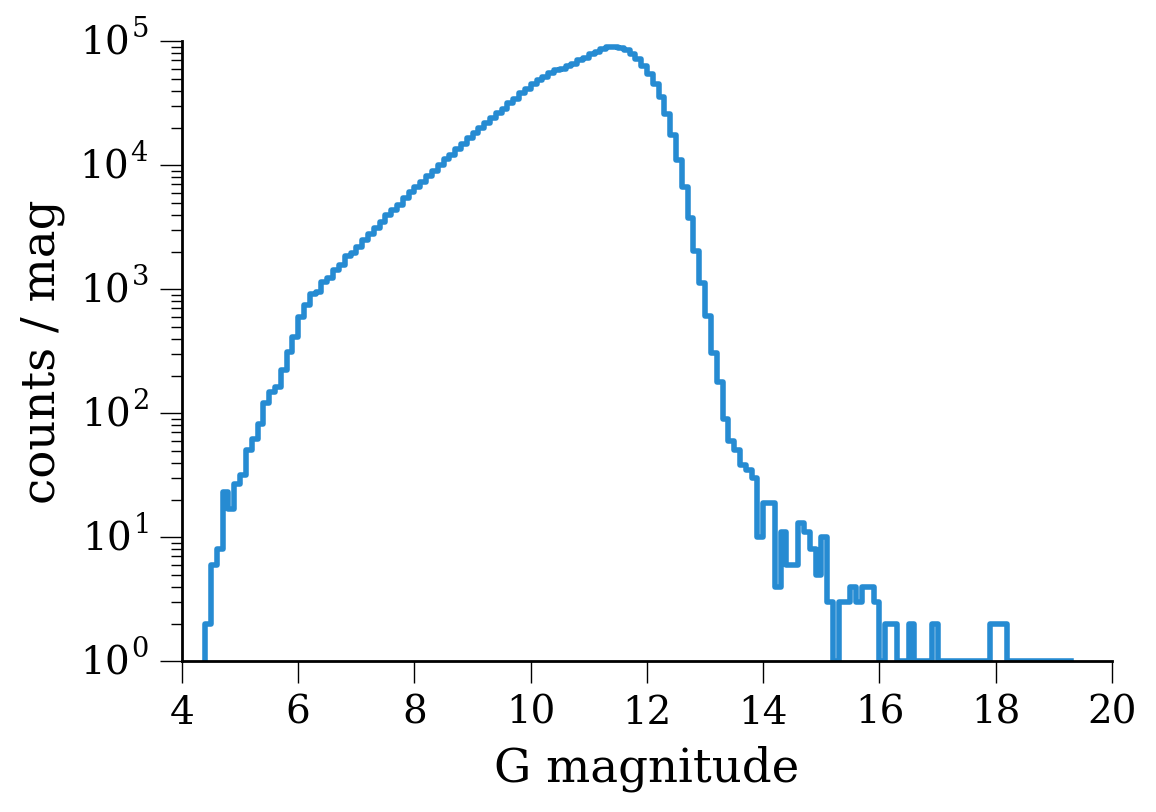

In [13]:
plt.step(data_tgas['val'], data_tgas['n'], 
         lw=2, where='pre', label='TGAS')
plt.yscale('log')
plt.xlabel('G magnitude')
plt.ylabel('counts / mag')
figrc.hide_axis('top right'.split())

**Note**: Creating the luminosity function for the full DR1 required more than 1 min and thefore an async query, which is not handled by this simple query interface.

# Stellar density map

Let's reproduce the stellar density map of TGAS stars with **all computations on the server side**.

Based on the histogram technique we used for the luminosity function, one can extend it to more than one dimension.

In [14]:
adql = QueryStr("""
select 
    count(*) as n, 
    round(l, 0) as x, 
    round(b, 0) as y
from 
    gaiadr1.tgas_source 
group by x, y
order by x, y
""")

*ADQL query*
```mysql

SELECT
    count(*) AS n,
    round(l, 0) AS x,
    round(b, 0) AS y
FROM
    gaiadr1.tgas_source
GROUP BY x, y
ORDER BY x, y

```

Run the query

In [15]:
data = timeit(gaia.query)(adql)

*Execution time*: 25.7 s

Below you can see that the table is flat (i.e, no 2d matrix) and it contains a number $n$ for each pair $(x,y)$. Note also that empty bins are not included.

In [16]:
data

n,x,y
int64,float64,float64
1,0.0,-88.0
1,0.0,-85.0
1,0.0,-84.0
1,0.0,-83.0
1,0.0,-82.0
1,0.0,-81.0
2,0.0,-80.0
3,0.0,-79.0
4,0.0,-78.0


Skipping polishing the projection

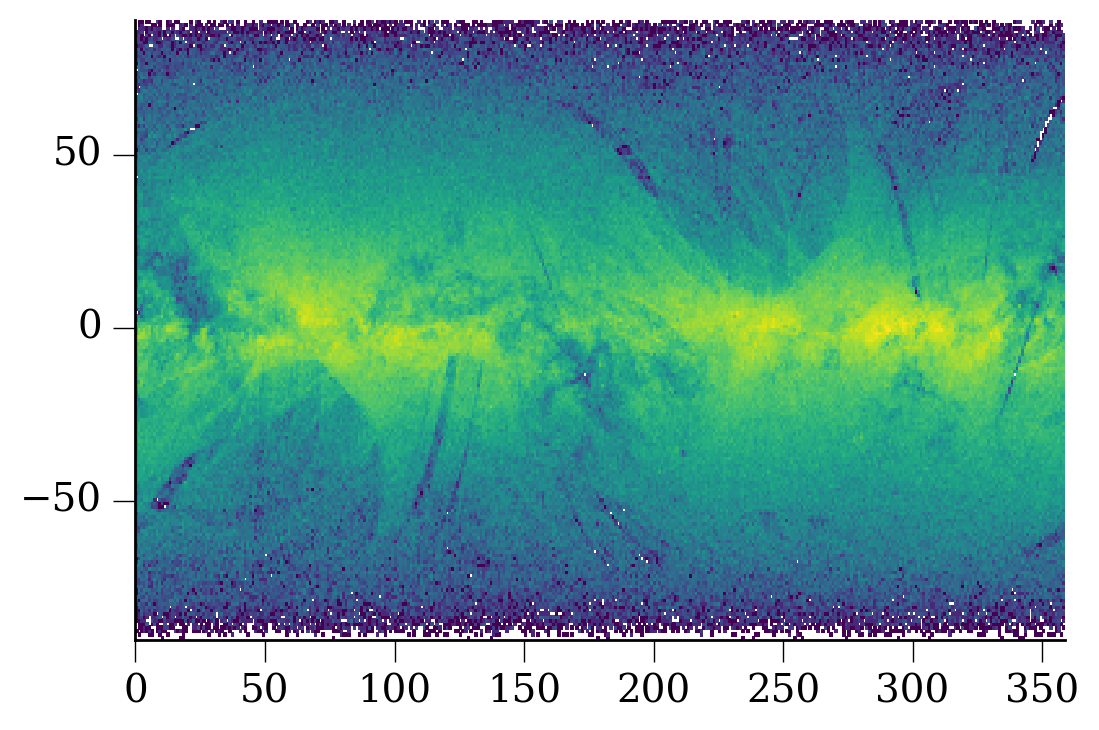

In [17]:
from matplotlib.colors import LogNorm
l = np.arange(0, 360, 1)
b = np.arange(-90, 90, 1)
n = np.zeros((len(l), len(b)))
ix = np.digitize(data['x'], l)
iy = np.digitize(data['y'], b)
n[ix - 1, iy - 1] = data['n']
plt.pcolormesh(l, b, n.T, 
               cmap=plt.cm.viridis, 
               norm=LogNorm())
figrc.hide_axis('top right'.split())
plt.xlim(l.min(), l.max())
plt.ylim(b.min(), b.max());

# Query around a position

Using the `region` objects, one can query around a `point`. Below is an example of **cone-search**, i.e., selecting stars within 2 degrees of an object:

```mysql
select * from gaiadr1.gaia_sources
where contains(point('ICRS', ra, dec), circle('ICRS',10.6847083,41.26875,2) ) = 1 
```
The `where` condition selects points from the data that are contained into the circle of given center and size.

Below we make the density map of stars around the same object. We can therefore combine the 2D-histogram above and the cone-search technique.

*Any idea of what object is the center of this selection?*

In [18]:
adql = QueryStr("""
select 
    count(*) as n, 
    round(l, 2) as latitude, 
    round(b, 2) as longitude
from 
    gaiadr1.gaia_source 
where 
    contains(point('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),
             circle('ICRS',10.6847083,41.26875,2) )=1  
group by latitude, longitude
order by latitude, longitude
""")

*ADQL query*
```mysql

SELECT
    count(*) AS n,
    round(l, 2) AS latitude,
    round(b, 2) AS longitude
FROM
    gaiadr1.gaia_source
WHERE
    contains(point('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),
             circle('ICRS',10.6847083,41.26875,2) )=1
GROUP BY latitude, longitude
ORDER BY latitude, longitude

```

Run the query

In [19]:
data = timeit(gaia.query)(adql)

*Execution time*: 13.7 s

Finally we plot the map

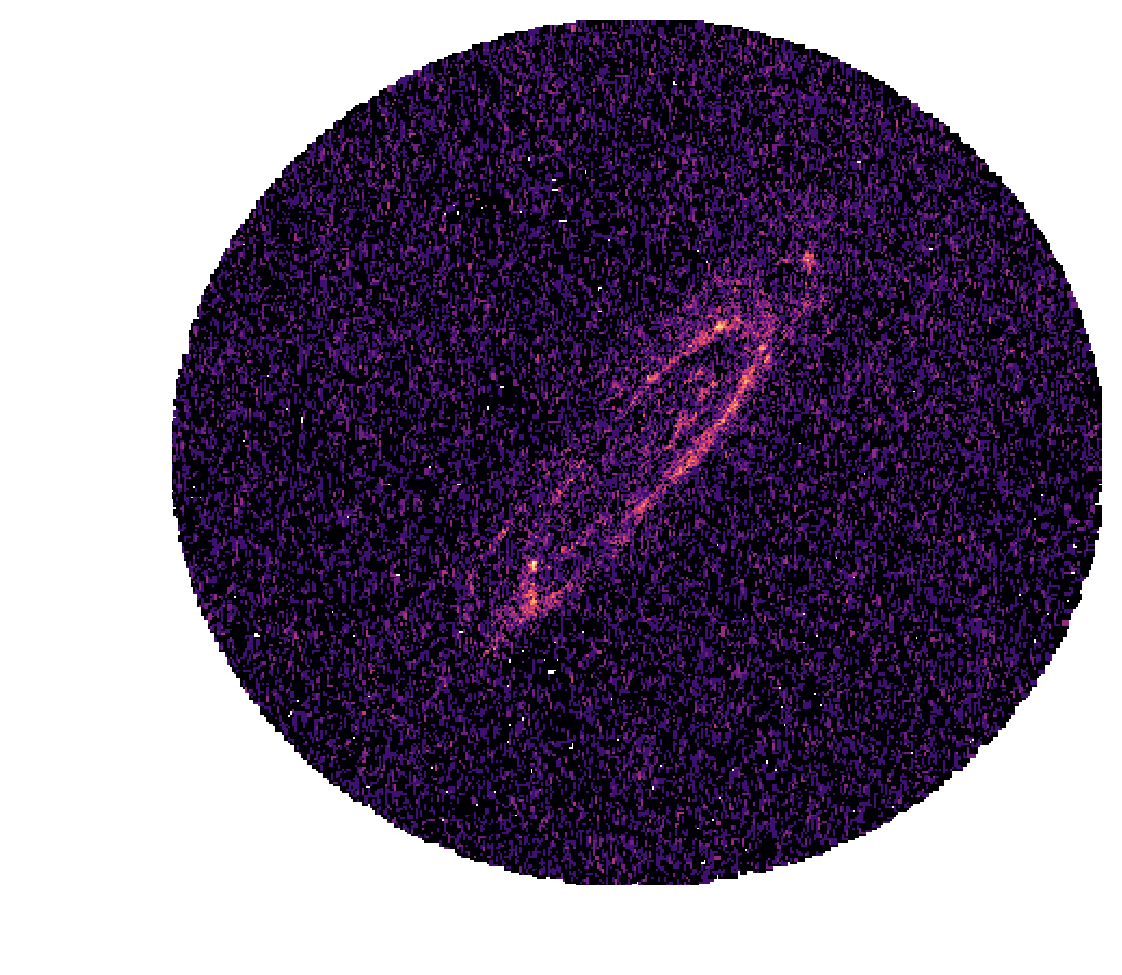

In [20]:
plt.figure(figsize=(6,6))
plt.subplot(111, aspect=1)
plt.scatter(data['latitude'], data['longitude'], c=data['n'], 
            edgecolor='None', s=6, rasterized=True, norm=LogNorm(),
            cmap=plt.cm.magma, marker='s'
           )
plt.xlim(data['latitude'].min(), data['latitude'].max())
plt.ylim(data['longitude'].min(), data['longitude'].max())
plt.axis('off');

Let's proceed to query around another object for example `M33`

ADQL does not provide a name resolver function. So you'll have to figure that for `M33` you need
```mysql
circle('ICRS',23.4621,30.6599417,0.5)
```

Alternatively, this python package provides a name resolver function based on the *CDS/Sesame service*.

```python
from tap import resolve
ra, dec = resolve('m33')
```
Below I show the latter option.

*ADQL query*
```mysql

SELECT
    count(*) AS n,
    round(l, 2) AS latitude,
    round(b, 2) AS longitude
FROM
    gaiadr1.gaia_source
WHERE
    contains(point('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),
             circle('ICRS',23.462100, 30.659942,0.5) )=1
GROUP BY latitude, longitude
ORDER BY latitude, longitude

```

*Execution time*: 922 ms

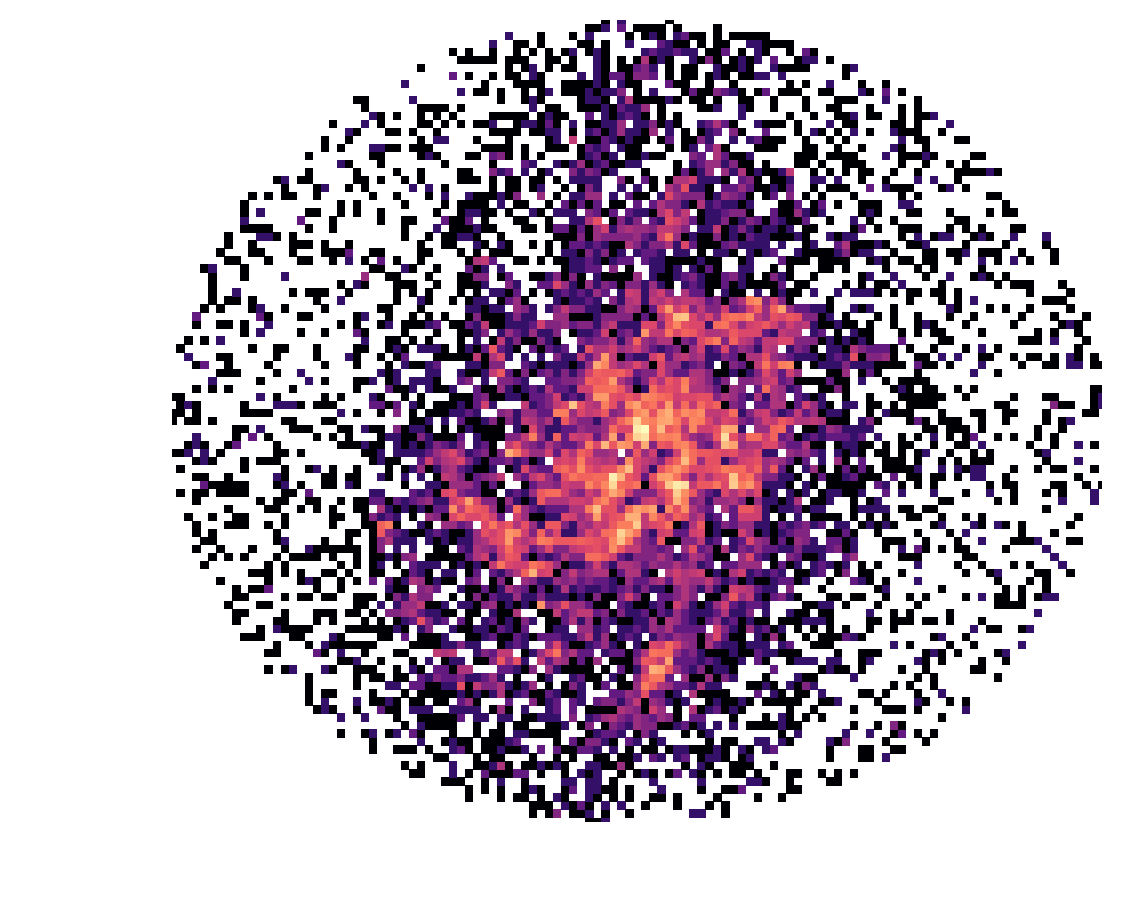

In [21]:
ra, dec = resolve('m33')
adql = QueryStr("""
select 
    count(*) as n, 
    round(l, 2) as latitude, 
    round(b, 2) as longitude
from 
    gaiadr1.gaia_source 
where 
    contains(point('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),
             circle('ICRS',{ra:f}, {dec:f},0.5) )=1  
group by latitude, longitude
order by latitude, longitude
""".format(ra=ra, dec=dec))
data = timeit(gaia.query)(adql)
plt.figure(figsize=(6,6))
plt.subplot(111, aspect=1)
plt.scatter(data['latitude'], data['longitude'], c=data['n'], 
            edgecolor='None', s=9, rasterized=True, norm=LogNorm(),
            cmap=plt.cm.magma, marker='s'
           )
plt.xlim(data['latitude'].min(), data['latitude'].max())
plt.ylim(data['longitude'].min(), data['longitude'].max())
plt.axis('off');

# Color-magnitude diagram of TGAS

One of the first results published by the Gaia Consortium was the color-magnitude diagram (CMD) of the TGAS data, showing how good the parallaxes are.

Let's reproduce the figure.

Let's make a binned CMD with bins of $0.01$ mag and $0.05$ mag in color and magnitude, respectively.
Additionally, we will need to use the parallax as distance measurements. As [Bailer-Jones 2015](http://adsabs.harvard.edu/abs/2015PASP..127..994B) showed one must be careful, thus let's only consider stars with $\varpi/\sigma_\varpi > 5$. One could also filter on photometric signal-to-noise (in flux).

In [22]:
adql = QueryStr("""
select 
    count(*) as n,
    floor((hip.bt_mag - hip.vt_mag) / 0.01) * 0.01 as color,
    floor((gaia.phot_g_mean_mag + 5*log10(gaia.parallax)-10) / 0.05) * 0.05 as mag
from 
    gaiadr1.tgas_source as gaia
inner join 
    public.tycho2 as hip
    on gaia.hip = hip.hip
where 
    gaia.parallax / gaia.parallax_error >= 5 
    and (2.5/log(10)) * (gaia.phot_g_mean_flux_error / gaia.phot_g_mean_flux) <= 0.05
group by color, mag
""")
data = timeit(gaia.query)(adql)

*ADQL query*
```mysql

SELECT
    count(*) AS n,
    floor((hip.bt_mag - hip.vt_mag) / 0.01) * 0.01 AS color,
    floor((gaia.phot_g_mean_mag + 5*log10(gaia.parallax)-10) / 0.05) * 0.05 AS mag
FROM
    gaiadr1.tgas_source AS gaia
INNER JOIN
    public.tycho2 AS hip
    ON gaia.hip = hip.hip
WHERE
    gaia.parallax / gaia.parallax_error >= 5
    AND (2.5/log(10)) * (gaia.phot_g_mean_flux_error / gaia.phot_g_mean_flux) <= 0.05
GROUP BY color, mag

```

*Execution time*: 6.42 s

Plotting the CMD is the only local operation.

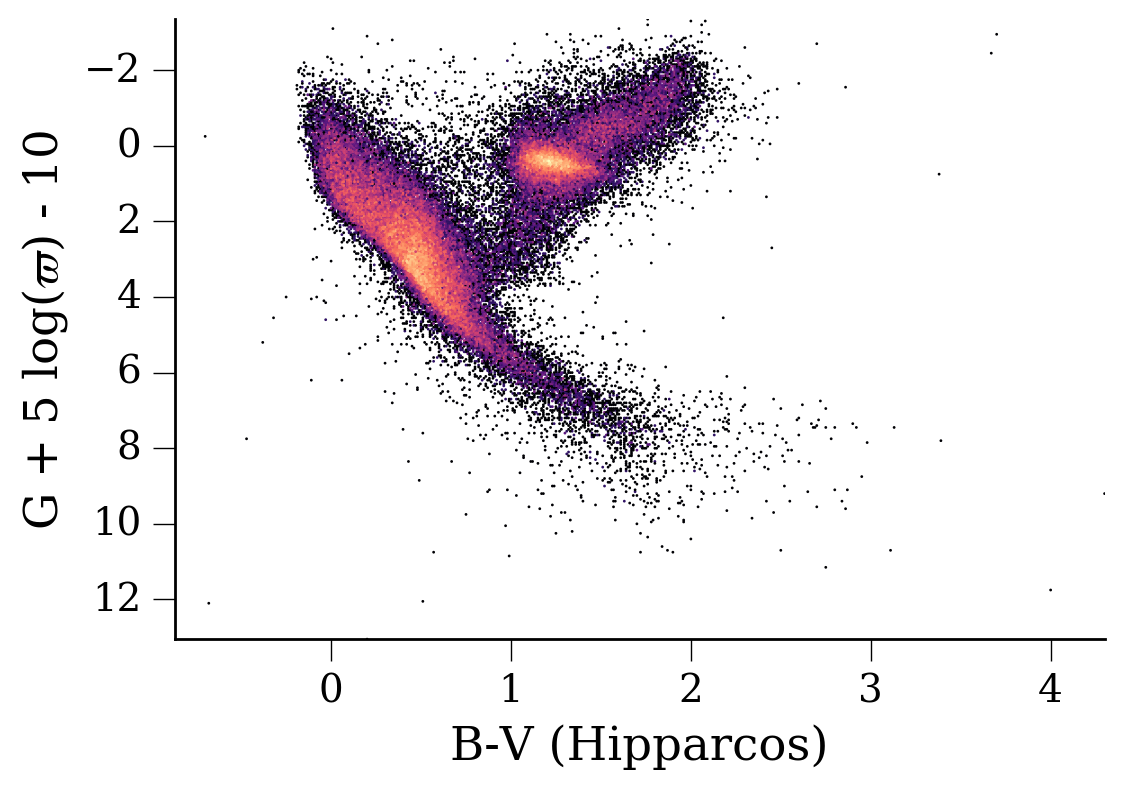

In [23]:
plt.scatter(data['color'], data['mag'], c=data['n'], 
            edgecolor='None', s=1, rasterized=True, norm=LogNorm(),
            cmap=plt.cm.magma, marker='o'
           )
plt.xlim(data['color'].min(), data['color'].max())
plt.ylim(data['mag'].max(), data['mag'].min())
plt.xlabel('B-V (Hipparcos)')
plt.ylabel(r'G + 5 log($\varpi$) - 10')
figrc.hide_axis('top right'.split())

# Using DR1 crossmatched catalogs: joining tables

Many surveys are already crossmatched by Gaia DPAC (Data Processing and Analysis Consortium). However the access may not be as trivial for many. It requires to join tables by some `id` values.

**Getting TGAS and Tycho2 missing Ids**

Note the use of `left outer join`, which adds to the left table (here `gaia`) the missing columns when and fills it in whenever possible.

In [24]:
adql = QueryStr("""
select top 10
        gaia.hip, gaia.tycho2_id, gaia.source_id,
        tycho2.bt_mag, tycho2.vt_mag, tycho2.e_bt_mag, tycho2.e_vt_mag
from 
        gaiadr1.tgas_source as gaia
left outer join
        public.tycho2 as tycho2 
        on gaia.tycho2_id = tycho2.id
""")
timeit(gaia.query)(adql)

*ADQL query*
```mysql

SELECT top 10
        gaia.hip, gaia.tycho2_id, gaia.source_id,
        tycho2.bt_mag, tycho2.vt_mag, tycho2.e_bt_mag, tycho2.e_vt_mag
FROM
        gaiadr1.tgas_source AS gaia
LEFT OUTER JOIN
        public.tycho2 AS tycho2
        ON gaia.tycho2_id = tycho2.id

```

*Execution time*: 135 ms

hip,tycho2_id,source_id,bt_mag,vt_mag,e_bt_mag,e_vt_mag
,,,'mag','mag','mag','mag'
int32,object,int64,float32,float32,float32,float32
--,1000-1009-1,4493714846038108800,12.762,12.157,0.236,0.193
--,1000-1016-1,4492839806583533312,11.131,10.695,0.057999998,0.061999999
--,1000-1018-1,4493575723457455872,12.224,11.849,0.155,0.163
--,1000-1043-1,4494114312356365568,10.274,9.2080002,0.035,0.021
--,1000-1068-1,4493519648365739008,11.95,10.608,0.106,0.048999999
--,1000-108-1,4493522603303232768,12.391,12.389,0.185,0.21600001
--,1000-1087-1,4493716048628949632,11.529,11.021,0.077,0.079999998
--,1000-1092-1,4492866469738055936,12.696,12.115,0.248,0.20900001


What happens if you do `inner join` instead?

In [25]:
adql = QueryStr("""
select top 10
    gaia.hip, gaia.tycho2_id, gaia.source_id,
    gaia.ra, gaia.ra_error, gaia.dec, gaia.dec_error, 
    gaia.parallax, gaia.parallax_error, gaia.pmra, gaia.pmra_error,
    gaia.pmdec, gaia.pmdec_error, gaia.ra_dec_corr, gaia.ra_parallax_corr,
    gaia.phot_g_n_obs, gaia.phot_g_mean_flux, gaia.phot_g_mean_flux_error,
    gaia.phot_g_mean_mag, gaia.phot_variable_flag, gaia.l, gaia.b,
    gaia.ecl_lon, gaia.ecl_lat, tycho2.bt_mag, tycho2.vt_mag,
    tycho2.e_bt_mag, tycho2.e_vt_mag, 
    allwise.allwise_oid, allwise.w1mpro,
    allwise.w1mpro_error, allwise.w2mpro, allwise.w2mpro_error,
    allwise.w3mpro, allwise.w3mpro_error, allwise.w4mpro,
    allwise.w4mpro_error, allwise.var_flag, allwise.w1mjd_mean,
    allwise.w2mjd_mean, allwise.w3mjd_mean, allwise.w4mjd_mean,
    allwise.w1gmag, allwise.w1gmag_error, allwise.w2gmag,
    allwise.w2gmag_error, allwise.w3gmag, allwise.w3gmag_error,
    allwise.w4gmag, allwise.w4gmag_error,
    tmass.tmass_oid, tmass.j_m, tmass.j_msigcom, tmass.h_m, tmass.h_msigcom,
    tmass.ks_m, tmass.ks_msigcom
from 
    gaiadr1.tgas_source as gaia
left outer join
    public.tycho2 as tycho2  
    on gaia.tycho2_id = tycho2.id
left outer join
    gaiadr1.allwise_best_neighbour as allwisexmatch  
    on gaia.source_id = allwisexmatch.source_id  
left outer join 
    gaiadr1.allwise_original_valid as allwise 
    on allwisexmatch.allwise_oid = allwise.allwise_oid  
left outer join 
    gaiadr1.tmass_best_neighbour as tmassxmatch
    on gaia.source_id = tmassxmatch.source_id  
left outer join
    gaiadr1.tmass_original_valid as tmass  
    on tmassxmatch.tmass_oid = tmass.tmass_oid
""")
data = timeit(gaia.query)(adql)

*ADQL query*
```mysql

SELECT top 10
    gaia.hip, gaia.tycho2_id, gaia.source_id,
    gaia.ra, gaia.ra_error, gaia.dec, gaia.dec_error,
    gaia.parallax, gaia.parallax_error, gaia.pmra, gaia.pmra_error,
    gaia.pmdec, gaia.pmdec_error, gaia.ra_dec_corr, gaia.ra_parallax_corr,
    gaia.phot_g_n_obs, gaia.phot_g_mean_flux, gaia.phot_g_mean_flux_error,
    gaia.phot_g_mean_mag, gaia.phot_variable_flag, gaia.l, gaia.b,
    gaia.ecl_lon, gaia.ecl_lat, tycho2.bt_mag, tycho2.vt_mag,
    tycho2.e_bt_mag, tycho2.e_vt_mag,
    allwise.allwise_oid, allwise.w1mpro,
    allwise.w1mpro_error, allwise.w2mpro, allwise.w2mpro_error,
    allwise.w3mpro, allwise.w3mpro_error, allwise.w4mpro,
    allwise.w4mpro_error, allwise.var_flag, allwise.w1mjd_mean,
    allwise.w2mjd_mean, allwise.w3mjd_mean, allwise.w4mjd_mean,
    allwise.w1gmag, allwise.w1gmag_error, allwise.w2gmag,
    allwise.w2gmag_error, allwise.w3gmag, allwise.w3gmag_error,
    allwise.w4gmag, allwise.w4gmag_error,
    tmass.tmass_oid, tmass.j_m, tmass.j_msigcom, tmass.h_m, tmass.h_msigcom,
    tmass.ks_m, tmass.ks_msigcom
FROM
    gaiadr1.tgas_source AS gaia
LEFT OUTER JOIN
    public.tycho2 AS tycho2
    ON gaia.tycho2_id = tycho2.id
LEFT OUTER JOIN
    gaiadr1.allwise_best_neighbour AS allwisexmatch
    ON gaia.source_id = allwisexmatch.source_id
LEFT OUTER JOIN
    gaiadr1.allwise_original_valid AS allwise
    ON allwisexmatch.allwise_oid = allwise.allwise_oid
LEFT OUTER JOIN
    gaiadr1.tmass_best_neighbour AS tmassxmatch
    ON gaia.source_id = tmassxmatch.source_id
LEFT OUTER JOIN
    gaiadr1.tmass_original_valid AS tmass
    ON tmassxmatch.tmass_oid = tmass.tmass_oid

```

*Execution time*: 513 ms

# Example

This example is from C. A. L. Bailer-Jones 

TGAS apparently has the nasty property that it does not report both Hipparcos and Tycho-2 Id at the same time but only one of the 2. However, when you need/want to have both, this starts to get a little bit tricky. 

Additionally CBJ wanted to do some selections on the parallax and proper motion for updating his stellar encounter study.

Below we select the various `id` values but fill the Tycho-2 ids for Hipparcos stars when available in the Tycho-2 data. Moreover, CBJ wants to filter stars based on their motion:

\begin{equation}
\frac{1000 \cdot 4.74047 \cdot \sqrt{\mu_\alpha^2 + \mu_\delta^2} / \varpi^2}{
\sqrt{ (\mu_\alpha^2 + \mu_\delta^2) \cdot (4.74047/\varpi)^2 + 500^2}
} < 10    
\end{equation}

where $4.74047$ is the equivalent of $1$ AU/yr in km/s and a radial velocity $R_V=500$ km/s.

In [30]:
adql = QueryStr("""
select 
    tgas.tycho2_id, tycho2.id, tgas.source_id, tgas.phot_g_mean_mag,
    tgas.ra, tgas.dec, tgas.parallax, tgas.pmra, tgas.pmdec, tgas.ra_error,
    tgas.dec_error, tgas.parallax_error, tgas.pmra_error, tgas.pmdec_error,
    tgas.ra_dec_corr, tgas.ra_parallax_corr, tgas.ra_pmra_corr,
    tgas.ra_pmdec_corr, tgas.dec_parallax_corr, tgas.dec_pmra_corr,
    tgas.dec_pmdec_corr, tgas.parallax_pmra_corr, tgas.parallax_pmdec_corr,
    tgas.pmra_pmdec_corr
from 
    gaiadr1.tgas_source as tgas
left outer join 
    public.tycho2 as tycho2
    on tgas.hip = tycho2.hip
where ( (
            1000 * 4.74047 * sqrt(power(tgas.pmra, 2) 
            + power(tgas.pmdec, 2)) / power(tgas.parallax, 2)
         ) /
         ( sqrt(
                (power(tgas.pmra, 2) 
                + power(tgas.pmdec, 2)) * power(4.74047 / tgas.parallax, 2)
                + power(500, 2) ) )
        ) < 10
""")
data = timeit(gaia.query)(adql)

*ADQL query*
```mysql

SELECT
    tgas.tycho2_id, tycho2.id, tgas.source_id, tgas.phot_g_mean_mag,
    tgas.ra, tgas.dec, tgas.parallax, tgas.pmra, tgas.pmdec, tgas.ra_error,
    tgas.dec_error, tgas.parallax_error, tgas.pmra_error, tgas.pmdec_error,
    tgas.ra_dec_corr, tgas.ra_parallax_corr, tgas.ra_pmra_corr,
    tgas.ra_pmdec_corr, tgas.dec_parallax_corr, tgas.dec_pmra_corr,
    tgas.dec_pmdec_corr, tgas.parallax_pmra_corr, tgas.parallax_pmdec_corr,
    tgas.pmra_pmdec_corr
FROM
    gaiadr1.tgas_source AS tgas
LEFT OUTER JOIN
    public.tycho2 AS tycho2
    ON tgas.hip = tycho2.hip
WHERE ( (
            1000 * 4.74047 * sqrt(power(tgas.pmra, 2)
            + power(tgas.pmdec, 2)) / power(tgas.parallax, 2)
         ) /
         ( sqrt(
                (power(tgas.pmra, 2)
                + power(tgas.pmdec, 2)) * power(4.74047 / tgas.parallax, 2)
                + power(500, 2) ) )
        ) < 10

```

*Execution time*: 48.5 s

In [31]:
data

tycho2_id,id,source_id,phot_g_mean_mag,ra,dec,parallax,pmra,pmdec,ra_error,dec_error,parallax_error,pmra_error,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr
,,,Magnitude[mag],Angle[deg],Angle[deg],Angle[mas],Angular Velocity[mas/year],Angular Velocity[mas/year],Angle[mas],Angle[mas],Angle[mas],Angular Velocity[mas/year],Angular Velocity[mas/year],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description]
object,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
--,958-1468-2,4464207424282475392,7.1198602385889878,243.32764068754435,13.52515172664916,40.800006093117474,178.74861089198765,-420.79960382877454,0.13104649484244665,0.16117893533526509,0.31043723997045586,0.064601257490059308,0.057930718633481051,0.29621336,-0.41621789,0.13098365,-0.006937637,-0.72872072,0.059074912,0.035693608,-0.095779195,-0.054888006,-0.16881736
--,74-2361-1,3255252986058161408,7.3695276910331131,64.006094273713217,0.4538119833656295,7.1071761246510494,24.354612773084156,-20.989618596126128,0.29644318347422099,0.096150567587155025,0.35108547075407198,0.06290689925903338,0.044369717746791014,0.49005944,-0.60830009,0.16846217,0.062295858,-0.1559172,0.085781589,0.063546307,-0.12095547,-0.046934858,0.028684257
--,96-602-1,3288082753998763904,10.510600620896234,73.024528087103548,6.4752772048123743,80.712650990387615,153.81772481777199,-305.57059728598551,0.26137398028662923,0.18054158432210146,0.33123962532366935,0.24514693508660898,0.14702434796739774,0.16450725,-0.013415399,-0.27141082,0.15436758,-0.13150086,0.18181257,-0.24545169,-0.11510445,0.054411348,-0.11440114
--,642-261-1,26101272172092160,10.955850032461074,39.161829394123984,12.207783096620895,20.383739875496488,240.67529562993337,-64.485729172308936,0.23582725901875154,0.20845897631933336,0.31685266385133043,0.1909477682115549,0.13636953348692929,-0.3721309,0.43391946,-0.070138283,-0.16176727,-0.71138328,-0.051297918,0.010662213,-0.050761018,-0.16512752,0.16369283
--,635-26-1,26283928541202816,10.809861178182299,37.22781819174989,12.089496787535225,39.919961935565183,-2.5864328472578642,81.626292496943535,0.60039515603994131,0.46890750268181058,0.67934103200164608,0.18503126835123951,0.1081967345680231,-0.50900584,0.56034762,0.059183244,-0.15097594,-0.70150846,-0.075549848,0.15309452,0.032147638,-0.1839865,0.20139986
--,705-228-1,3338162725508646528,10.057800898776822,83.060306350812724,9.8199099636248448,77.77121731583712,-180.0535819052561,-216.91689382915277,0.40115072093741344,0.53875097725055132,0.61362773790439706,0.19852981735012187,0.10421063302057142,-0.37349886,0.24006249,0.059844881,-0.047105495,-0.76504147,-0.035682362,0.17846557,0.065704599,-0.13622048,0.052898854
--,883-319-2,3731076710381126912,8.1492894201797128,196.12815296905151,8.6531822316745419,5.1696155054476867,16.791367641792707,0.15321456418562637,0.30133273705467556,0.19938605707508514,0.34002505864489424,0.079280953996536327,0.049291718311859016,-0.71896017,-0.61844242,0.11187758,-0.071467325,0.47721675,-0.064067535,0.15949973,-0.060346734,0.020644929,-0.4326793
--,993-77-1,4489070130967038720,11.093453539211243,265.77440288247851,9.0750980412265125,17.64909121187484,-32.322782317896724,187.88341033401773,0.19190892142781865,0.20035539243054135,0.25557908589771844,0.18762798949759626,0.14448000991756382,-0.073481336,0.094857119,-0.26464456,-0.062460415,-0.10070089,-0.12583351,-0.1455414,0.049493775,0.014614867,-0.15881599


In [32]:
adql = QueryStr("""
select 
    tgas.tycho2_id, tycho2.id, tgas.source_id, tgas.phot_g_mean_mag,
    tgas.ra, tgas.dec, tgas.parallax, tgas.pmra, tgas.pmdec, tgas.ra_error,
    tgas.dec_error, tgas.parallax_error, tgas.pmra_error, tgas.pmdec_error,
    tgas.ra_dec_corr, tgas.ra_parallax_corr, tgas.ra_pmra_corr,
    tgas.ra_pmdec_corr, tgas.dec_parallax_corr, tgas.dec_pmra_corr,
    tgas.dec_pmdec_corr, tgas.parallax_pmra_corr, tgas.parallax_pmdec_corr,
    tgas.pmra_pmdec_corr
from 
    gaiadr1.tgas_source as tgas
left outer join 
    public.tycho2 as tycho2
    on tgas.hip = tycho2.hip
where ( (
            1000 * 4.74047 * sqrt(power(tgas.pmra, 2) 
            + power(tgas.pmdec, 2)) / power(tgas.parallax, 2)
         ) /
         ( sqrt(
                (power(tgas.pmra, 2) 
                + power(tgas.pmdec, 2)) * power(4.74047 / tgas.parallax, 2)
                + power(500, 2) ) )
        ) < 10
""")
gaia.query_async(adql).get()

*ADQL query*
```mysql

SELECT
    tgas.tycho2_id, tycho2.id, tgas.source_id, tgas.phot_g_mean_mag,
    tgas.ra, tgas.dec, tgas.parallax, tgas.pmra, tgas.pmdec, tgas.ra_error,
    tgas.dec_error, tgas.parallax_error, tgas.pmra_error, tgas.pmdec_error,
    tgas.ra_dec_corr, tgas.ra_parallax_corr, tgas.ra_pmra_corr,
    tgas.ra_pmdec_corr, tgas.dec_parallax_corr, tgas.dec_pmra_corr,
    tgas.dec_pmdec_corr, tgas.parallax_pmra_corr, tgas.parallax_pmdec_corr,
    tgas.pmra_pmdec_corr
FROM
    gaiadr1.tgas_source AS tgas
LEFT OUTER JOIN
    public.tycho2 AS tycho2
    ON tgas.hip = tycho2.hip
WHERE ( (
            1000 * 4.74047 * sqrt(power(tgas.pmra, 2)
            + power(tgas.pmdec, 2)) / power(tgas.parallax, 2)
         ) /
         ( sqrt(
                (power(tgas.pmra, 2)
                + power(tgas.pmdec, 2)) * power(4.74047 / tgas.parallax, 2)
                + power(500, 2) ) )
        ) < 10

```

Query Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1479127182720O
Job id: 1479127182720O


tycho2_id,id,source_id,phot_g_mean_mag,ra,dec,parallax,pmra,pmdec,ra_error,dec_error,parallax_error,pmra_error,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr
,,,Magnitude[mag],Angle[deg],Angle[deg],Angle[mas],Angular Velocity[mas/year],Angular Velocity[mas/year],Angle[mas],Angle[mas],Angle[mas],Angular Velocity[mas/year],Angular Velocity[mas/year],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description]
object,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
--,958-1468-2,4464207424282475392,7.1198602385889878,243.32764068754435,13.52515172664916,40.800006093117474,178.74861089198765,-420.79960382877454,0.13104649484244665,0.16117893533526509,0.31043723997045586,0.064601257490059308,0.057930718633481051,0.29621336,-0.41621789,0.13098365,-0.006937637,-0.72872072,0.059074912,0.035693608,-0.095779195,-0.054888006,-0.16881736
--,74-2361-1,3255252986058161408,7.3695276910331131,64.006094273713217,0.4538119833656295,7.1071761246510494,24.354612773084156,-20.989618596126128,0.29644318347422099,0.096150567587155025,0.35108547075407198,0.06290689925903338,0.044369717746791014,0.49005944,-0.60830009,0.16846217,0.062295858,-0.1559172,0.085781589,0.063546307,-0.12095547,-0.046934858,0.028684257
--,96-602-1,3288082753998763904,10.510600620896234,73.024528087103548,6.4752772048123743,80.712650990387615,153.81772481777199,-305.57059728598551,0.26137398028662923,0.18054158432210146,0.33123962532366935,0.24514693508660898,0.14702434796739774,0.16450725,-0.013415399,-0.27141082,0.15436758,-0.13150086,0.18181257,-0.24545169,-0.11510445,0.054411348,-0.11440114
--,642-261-1,26101272172092160,10.955850032461074,39.161829394123984,12.207783096620895,20.383739875496488,240.67529562993337,-64.485729172308936,0.23582725901875154,0.20845897631933336,0.31685266385133043,0.1909477682115549,0.13636953348692929,-0.3721309,0.43391946,-0.070138283,-0.16176727,-0.71138328,-0.051297918,0.010662213,-0.050761018,-0.16512752,0.16369283
--,635-26-1,26283928541202816,10.809861178182299,37.22781819174989,12.089496787535225,39.919961935565183,-2.5864328472578642,81.626292496943535,0.60039515603994131,0.46890750268181058,0.67934103200164608,0.18503126835123951,0.1081967345680231,-0.50900584,0.56034762,0.059183244,-0.15097594,-0.70150846,-0.075549848,0.15309452,0.032147638,-0.1839865,0.20139986
--,705-228-1,3338162725508646528,10.057800898776822,83.060306350812724,9.8199099636248448,77.77121731583712,-180.0535819052561,-216.91689382915277,0.40115072093741344,0.53875097725055132,0.61362773790439706,0.19852981735012187,0.10421063302057142,-0.37349886,0.24006249,0.059844881,-0.047105495,-0.76504147,-0.035682362,0.17846557,0.065704599,-0.13622048,0.052898854
--,883-319-2,3731076710381126912,8.1492894201797128,196.12815296905151,8.6531822316745419,5.1696155054476867,16.791367641792707,0.15321456418562637,0.30133273705467556,0.19938605707508514,0.34002505864489424,0.079280953996536327,0.049291718311859016,-0.71896017,-0.61844242,0.11187758,-0.071467325,0.47721675,-0.064067535,0.15949973,-0.060346734,0.020644929,-0.4326793
--,993-77-1,4489070130967038720,11.093453539211243,265.77440288247851,9.0750980412265125,17.64909121187484,-32.322782317896724,187.88341033401773,0.19190892142781865,0.20035539243054135,0.25557908589771844,0.18762798949759626,0.14448000991756382,-0.073481336,0.094857119,-0.26464456,-0.062460415,-0.10070089,-0.12583351,-0.1455414,0.049493775,0.014614867,-0.15881599


As you can see **this does not return the same number of entries but many more than the `sync` mode.**

This can be for many reasons (esp. a bug of the service) but it could be that one of the `sync` mode limits was reached. Most likely the 1min time limit, but the reported time is still under that...

# Testing TAPVizieR

The VizieR ADQL service (http://tapvizier.u-strasbg.fr/) a service is hosted by the CDS - Strasbourg allows access to any VizieR table and catalog. The same operations are provided through the ADQL protocols. 

Below I reproduce all examples using the TAPVizieR Service.

**Important note**: column and table names in Vizier are not identical to the Gaia Archive ones

**Testing interface**

In [33]:
adql = QueryStr("""
select top 100
    gaia.source_id, gaia.hip,
    gaia.phot_g_mean_mag+5*log10(gaia.parallax)-10 as g_mag_abs_gaia,
    gaia.phot_g_mean_mag+5*log10(hip.plx)-10 as g_mag_abs_hip,
    hip."B-V"
from 
    "I/337/tgas" as gaia
inner join 
    "I/311/hip2" as hip
    on gaia.hip = hip.HIP
where
    gaia.parallax/gaia.parallax_error >= 5 
    and hip.Plx/hip.e_Plx >= 5 
    and hip."e_B-V" > 0.0 and hip."e_B-V" <= 0.05 
    and (2.5/log(10))*(gaia.phot_g_mean_flux_error/gaia.phot_g_mean_flux) <= 0.05
""")

vizier = TAPVizieR()
result = timeit(vizier.query)(adql)
result

*ADQL query*
```mysql

SELECT top 100
    gaia.source_id, gaia.hip,
    gaia.phot_g_mean_mag+5*log10(gaia.parallax)-10 AS g_mag_abs_gaia,
    gaia.phot_g_mean_mag+5*log10(hip.plx)-10 AS g_mag_abs_hip,
    hip."B-V"
FROM
    "I/337/tgas" AS gaia
INNER JOIN
    "I/311/hip2" AS hip
    ON gaia.hip = hip.HIP
WHERE
    gaia.parallax/gaia.parallax_error >= 5
    AND hip.Plx/hip.e_Plx >= 5
    AND hip."e_B-V" > 0.0 AND hip."e_B-V" <= 0.05
    AND (2.5/log(10))*(gaia.phot_g_mean_flux_error/gaia.phot_g_mean_flux) <= 0.05

```

*Execution time*: 1.11 s

source_id [1],hip [1],g_mag_abs_gaia [1],g_mag_abs_hip [1],B-V [1]
,,mag,mag,mag
int64,int32,float64,float64,float64
4687774147220506496,6812,1.85137678654,1.90017597299,0.962
4687785073611638144,7142,4.8397158847,5.24915846664,0.739
4688027619006146944,7256,2.64061888525,2.63613237042,0.389
4688217112963284480,7814,3.65349275211,3.56609011335,0.59
4688292532592267264,1113,5.20891724857,5.3288419309,0.743
4688376164190784384,698,-0.361463990472,-0.367487496164,1.326
4688399700615057024,1953,3.91250851253,3.78855540529,0.594
4688654546792333952,879,4.05457755693,4.02124289603,0.551


**TGAS Luminosity function**

*ADQL query*
```mysql

SELECT
    count(*) AS n,
    round(gaia.phot_g_mean_mag, 1) AS val
FROM
    "I/337/tgas" AS gaia
GROUP BY val
ORDER BY val

```

*Execution time*: 4.48 s

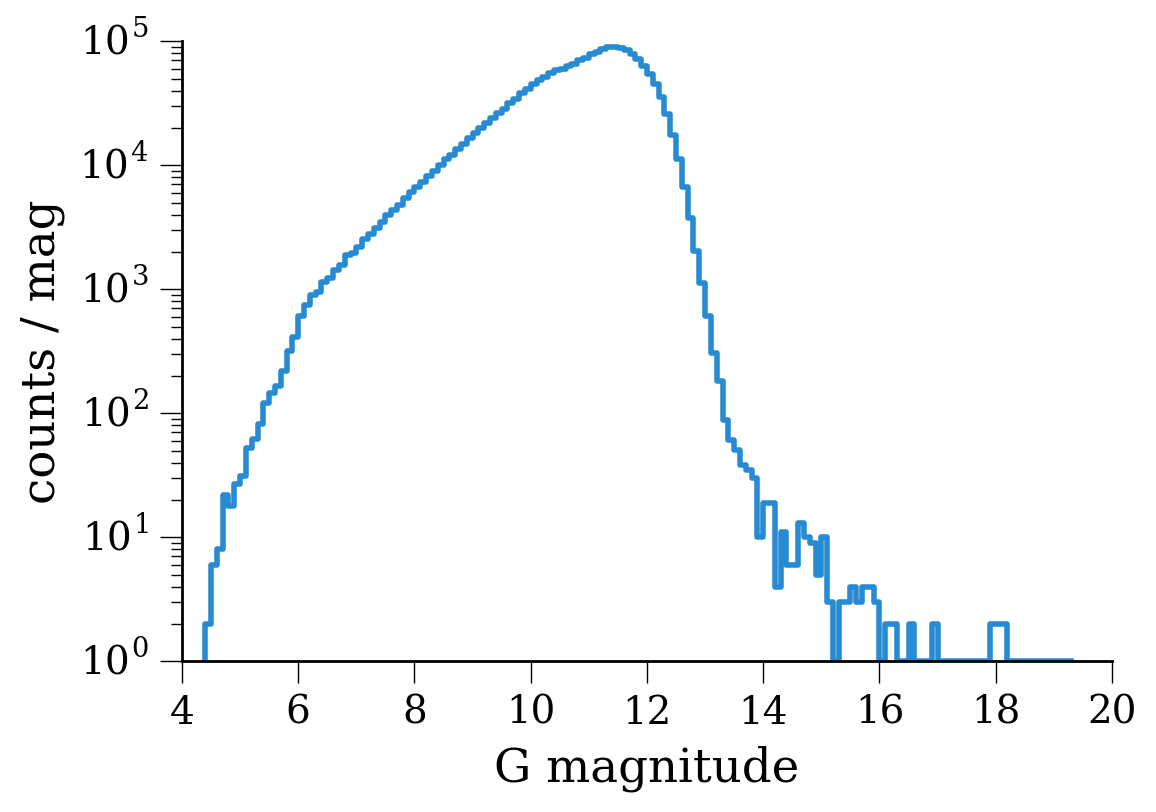

In [34]:
adql = QueryStr("""
select 
    count(*) as n, 
    round(gaia.phot_g_mean_mag, 1) as val
from 
    "I/337/tgas" as gaia
group by val
order by val
""")
data_tgas = timeit(vizier.query)(adql)

# Apparently some parsing issues in TAPVizieR...
n = [int(k) for k in data_tgas['n']]
vals = [float(k) for k in data_tgas['val']]
#
plt.step(vals, n, lw=2, where='pre', label='TGAS')
plt.yscale('log')
plt.xlabel('G magnitude')
plt.ylabel('counts / mag')
figrc.hide_axis('top right'.split())

**TGAS density map in l,b coordinates**

*ADQL query*
```mysql

SELECT
    count(*) AS n,
    round(glon, 0) AS x,
    round(glat, 0) AS y
FROM
    "I/337/tgas"
GROUP BY x, y
ORDER BY x, y

```

*Execution time*: 22.5 s

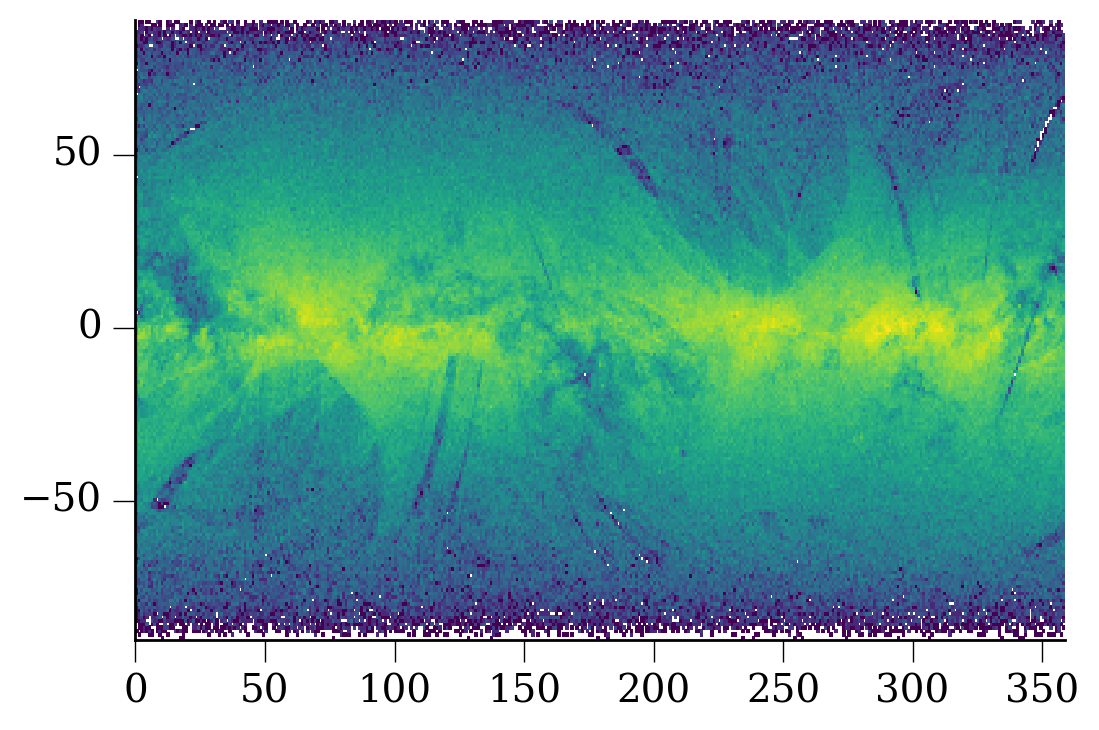

In [35]:
adql = QueryStr("""
select 
    count(*) as n, 
    round(glon, 0) as x, 
    round(glat, 0) as y
from 
    "I/337/tgas"
group by x, y
order by x, y
""")
data = timeit(vizier.query)(adql)

from matplotlib.colors import LogNorm
dx = [float(k) for k in data['x']]
dy = [float(k) for k in data['y']]
dn = [int(k) for k in data['n']]
l = np.arange(0, 360, 1)
b = np.arange(-90, 90, 1)
n = np.zeros((len(l), len(b)))
ix = np.digitize(dx, l)
iy = np.digitize(dy, b)
n[ix - 1, iy - 1] = dn
plt.pcolormesh(l, b, n.T, 
               cmap=plt.cm.viridis, 
               norm=LogNorm())
figrc.hide_axis('top right'.split())
plt.xlim(l.min(), l.max())
plt.ylim(b.min(), b.max());

**M31 cone-search**

*ADQL query*
```mysql

SELECT
    count(*) AS n,
    round(ra, 2) AS latitude,
    round(dec, 2) AS longitude
FROM
    "I/337/gaia"
WHERE
    contains(point('ICRS', ra, dec),
             circle('ICRS',10.6847083,41.26875,2) )=1
GROUP BY latitude, longitude
ORDER BY latitude, longitude

```

*Execution time*: 4.51 s

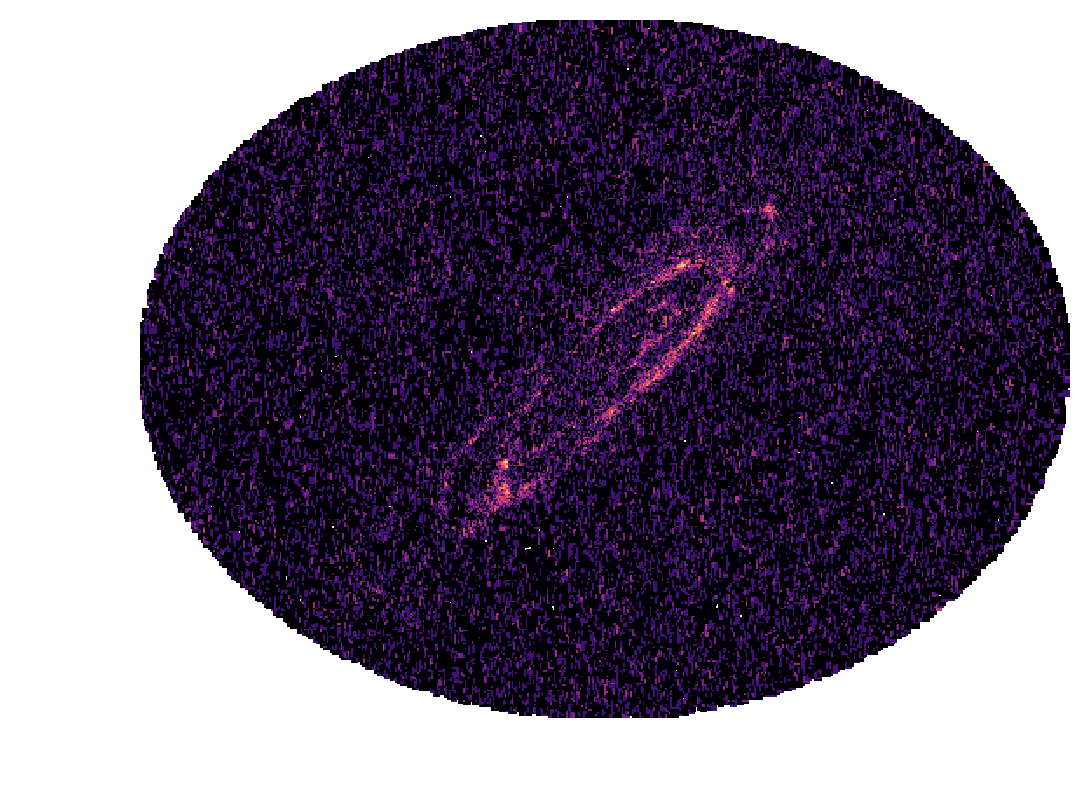

In [36]:
adql = QueryStr("""
select
    count(*) as n, 
    round(ra, 2) as latitude, 
    round(dec, 2) as longitude
from 
    "I/337/gaia"
where 
    contains(point('ICRS', ra, dec),
             circle('ICRS',10.6847083,41.26875,2) )=1  
group by latitude, longitude
order by latitude, longitude
""")
data = timeit(vizier.query)(adql)

lat = [float(k) for k in data['latitude']]
lon = [float(k) for k in data['longitude']]
n = [int(k) for k in data['n']]

plt.figure(figsize=(6,6))
plt.subplot(111, aspect=1)
plt.scatter(lat, lon, c=n,
            edgecolor='None', s=6, rasterized=True, norm=LogNorm(),
            cmap=plt.cm.magma, marker='s'
           )
plt.xlim(min(lat), max(lat))
plt.ylim(min(lon), max(lon))
plt.axis('off');

**M33 cone search**

*ADQL query*
```mysql

SELECT
    count(*) AS n,
    round(ra, 2) AS latitude,
    round(dec, 2) AS longitude
FROM
    gaiadr1.gaia_source
WHERE
    contains(point('ICRS', ra, dec),
             circle('ICRS',23.4621,30.6599417,0.5) )=1
GROUP BY latitude, longitude
ORDER BY latitude, longitude

```

*Execution time*: 920 ms

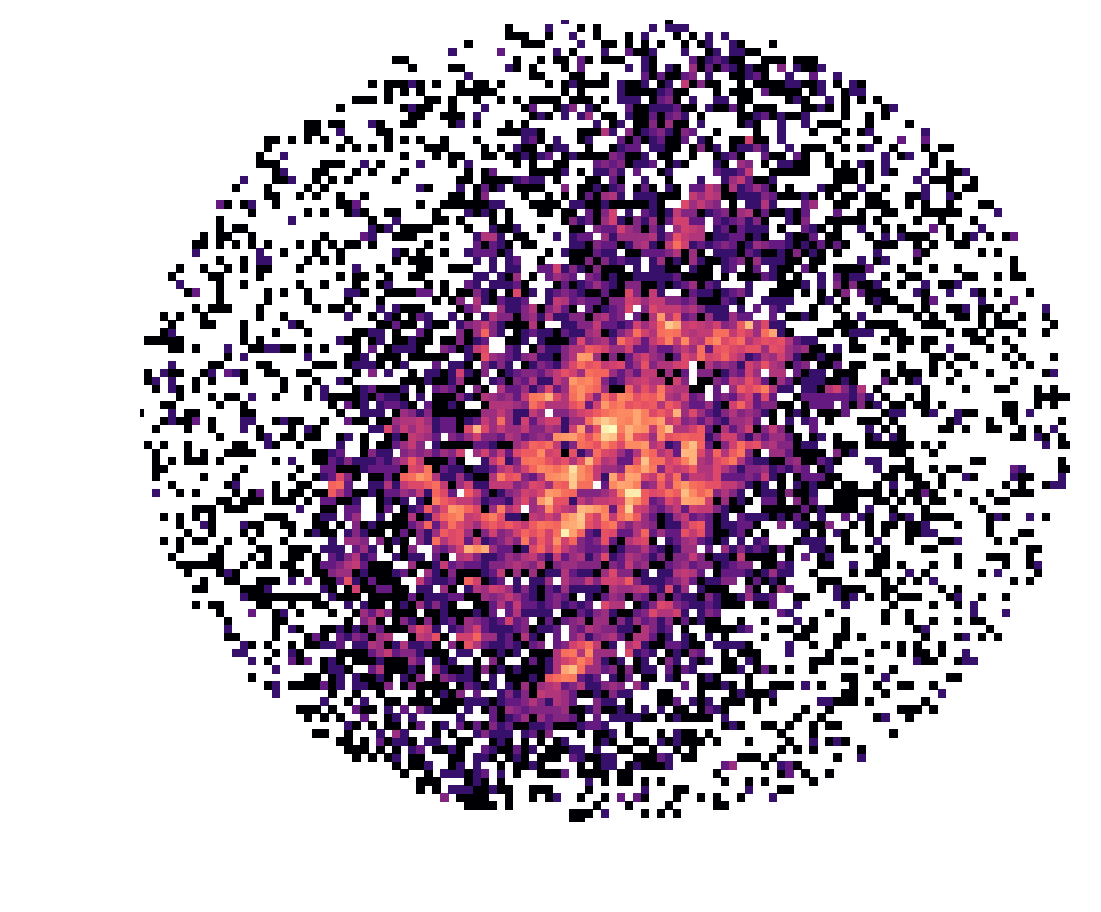

In [37]:
adql = QueryStr("""
select 
    count(*) as n, 
    round(ra, 2) as latitude, 
    round(dec, 2) as longitude
from 
    gaiadr1.gaia_source 
where 
    contains(point('ICRS', ra, dec),
             circle('ICRS',23.4621,30.6599417,0.5) )=1  
group by latitude, longitude
order by latitude, longitude
""")
data = timeit(gaia.query)(adql)

lat = [float(k) for k in data['latitude']]
lon = [float(k) for k in data['longitude']]
n = [int(k) for k in data['n']]

plt.figure(figsize=(6,6))
plt.subplot(111, aspect=1)
plt.scatter(lat, lon, c=n,
            edgecolor='None', s=9, rasterized=True, norm=LogNorm(),
            cmap=plt.cm.magma, marker='s'
           )
plt.xlim(min(lat), max(lat))
plt.ylim(min(lon), max(lon))
plt.axis('off');

**TGAS CMD**

*ADQL query*
```mysql

SELECT
    count(*) AS n,
    floor((hip."B-V") / 0.01) * 0.01 AS color,
    floor((gaia.phot_g_mean_mag + 5*log10(gaia.parallax)-10) / 0.05) * 0.05 AS mag
FROM
    "I/337/tgas" AS gaia
INNER JOIN
    "I/311/hip2" AS hip
    ON gaia.hip = hip.HIP
WHERE
    gaia.parallax/gaia.parallax_error >= 5
    AND hip."e_B-V" > 0.0 AND hip."e_B-V" <= 0.05
    AND hip.Plx/hip.e_Plx >= 5
    AND (2.5/log(10))*(gaia.phot_g_mean_flux_error/gaia.phot_g_mean_flux) <= 0.05
GROUP BY color, mag

```

*Execution time*: 9.46 s

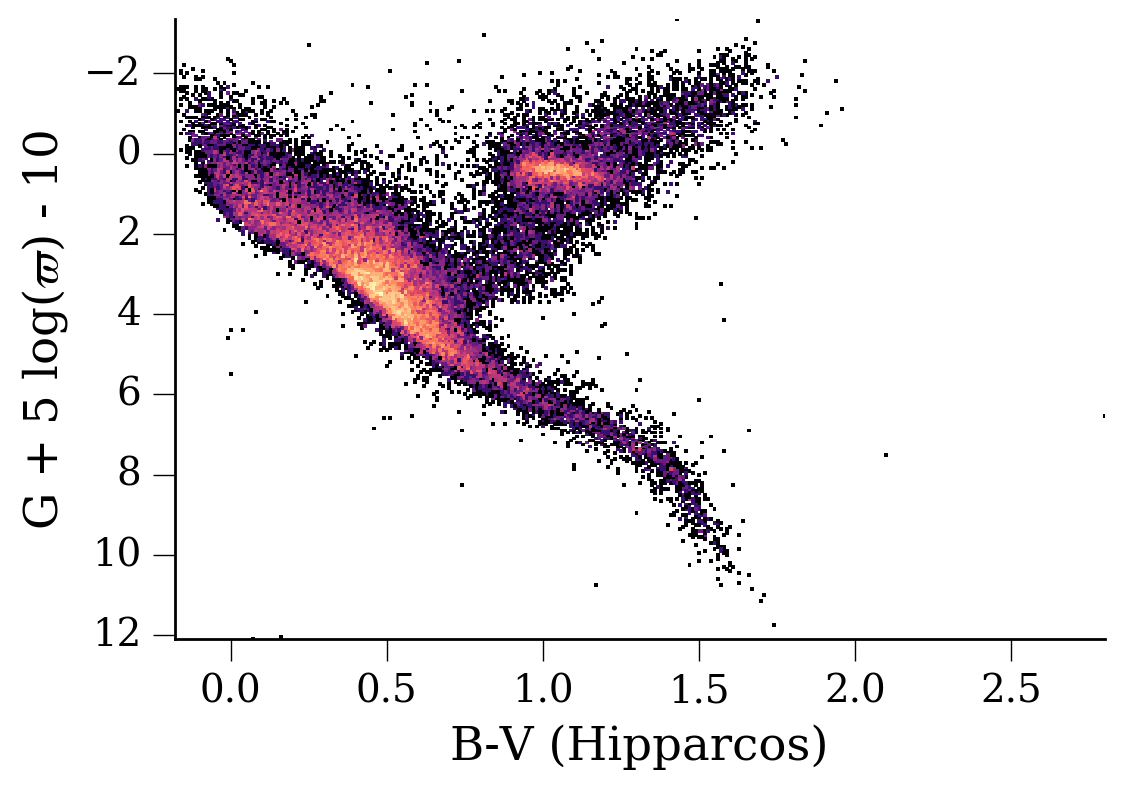

In [38]:
adql = QueryStr("""
select
    count(*) as n,
    floor((hip."B-V") / 0.01) * 0.01 as color,
    floor((gaia.phot_g_mean_mag + 5*log10(gaia.parallax)-10) / 0.05) * 0.05 as mag
from 
    "I/337/tgas" as gaia
inner join 
    "I/311/hip2" as hip
    on gaia.hip = hip.HIP
where
    gaia.parallax/gaia.parallax_error >= 5 
    and hip."e_B-V" > 0.0 and hip."e_B-V" <= 0.05 
    and hip.Plx/hip.e_Plx >= 5 
    and (2.5/log(10))*(gaia.phot_g_mean_flux_error/gaia.phot_g_mean_flux) <= 0.05
group by color, mag
""")
data = timeit(vizier.query)(adql)
color = [float(k) for k in data['color']]
mag = [float(k) for k in data['mag']]
n = [int(k) for k in data['n']]
plt.scatter(color, mag, c=n, 
            edgecolor='None', s=2, rasterized=True, norm=LogNorm(),
            cmap=plt.cm.magma, marker='s'
           )
plt.xlim(min(color), max(color))
plt.ylim(max(mag), min(mag))
plt.xlabel('B-V (Hipparcos)')
plt.ylabel(r'G + 5 log($\varpi$) - 10')
figrc.hide_axis('top right'.split())

# Other example

Based on [Watkins et al 2016.](https://arxiv.org/abs/1611.03170)

**Paper Abstract**
They perform a systematic search for Galactic globular cluster (GC) stars in the *Tycho-Gaia Astrometric Solution*
(TGAS) catalog that formed part of Gaia Data Release 1 (DR1), and identify 5 members of *NGC 104* (47 Tucanae), 1 member of *NGC 5272* (M 3), 5 members of *NGC 6121* (M 4), 7 members of *NGC 6397*, and 2 members of *NGC 6656* (M 22). 

By taking a weighted average of the member stars, fully **accounting for the correlations between parameter estimates**, **they estimate the parallax (and, hence, distance) and proper motion (PM) of the GCs**. This provides a homogeneous PM study of multiple GCs based on an astrometric catalogue with small and well-controlled systematic errors, and yields random PM errors that are similar to existing measurements. Detailed comparison to the available Hubble Space Telescope (HST) measurements generally shows excellent agreement, validating the astrometric quality of both TGAS and HST. 

By contrast, comparison to ground-based measurements shows that some of those must have systematic errors exceeding the random errors. Our parallax estimates have uncertainties an order of magnitude larger than previous studies, but nevertheless imply distances consistent with previous estimates. By combining our PM measurements with literature positions, distances and radial velocities, we measure Galactocentric space motions for the clusters and find that these are also in good agreement with previous orbital analyses. 

Our results highlight the future promise of Gaia for the determining accurate distances and PMs of Galactic GCs, which will provide crucial constraints on the near end of the cosmic distance ladder, and provide accurate GC orbital histories.


**method**
For each cluster, they calculate the likelihood of each nearby stars of being a cluster member by decomposing this likelihood into a positional part $L_{\alpha\delta,i}$ and a motion part $L_{\varpi\mu,i}$. 

On the one hand, stars close to the cluster centre of the cluster are more likely to be members than stars near to the $2\,R_{tidal}$ boundary, so we also calculate the likelihood of a star $i$ with coordinates $(\alpha_i, \delta_i)$ being a member of the GC with centre $(\alpha_{GC}, \delta_{GC})$ as,

\begin{eqnarray}
L_{\alpha\delta,i} &=& p(\alpha_i, \delta_i | \alpha_{GC}, \delta_{GC}, \sigma)
&=& \exp\left[-\frac{1}{2\sigma^2} \left((\alpha_i - \alpha_{GC})^2 + (\delta_i - \delta_{GC})^2\right) \right].
\end{eqnarray}

where they use $\sigma = \frac{1}{2} R_{tidal}$ to account for the approximate extent of the cluster. **The uncertainties on the cluster centre coordinates and on the positions of the stars are negligible compared to the extent of the cluster, so we neglect the measurement errors in this calculation.**

On the other hand, for a star $i$ with parallax  and PM measurements $m_i = (\varpi, \mu_\alpha, \mu_\delta)$, and covariance $C_i$, they ask what is the likelihood $L_{\varpi\mu,i}$ that this star is a member of a GC with measurements $m_{GC}$ and covariance $C_{GC}$,

\begin{eqnarray}
L_{\varpi\mu,i} &=& p(m_i | C_i, m_{GC}, C_{GC})\\
&=& \frac{1}{
\left[(2\pi)^3   |\det(C_{i} + C_{GC})|\right]^{1/2}}\,\exp\left[-\frac{1}{2} (m_i - m_{GC})^T \cdot (C_{i} + C_{GC})^{-1} \cdot (m_i - m_{GC}) \right].
\end{eqnarray}
The above is a standard 3-dimensional Gaussian. 

To construct the GC covariance matrix $C_{GC}$, they assume that the errors are uncorrelated, so the diagonal terms are the squared uncertainties on the parallax and PM measurements and the off-diagonal elements are zero. 
They further add the GC velocity dispersion (H96) in quadrature to the PM terms to account for the expected spread in velocities.
\begin{eqnarray}
C_{GC} = \left[\begin{matrix}
 \sigma^2_\varpi & 0  & 0\\ 
 0 & \mu^2_\alpha + \sigma^2_v  & 0 \\ 
 0 & 0 & \mu^2_\delta + \sigma^2_v
\end{matrix}\right]
\end{eqnarray}

additionally, (they do not explain but worth mentioning) the covariance matrix for the stars $C_i$ is given by
\begin{eqnarray}
C_{i} = \left[\begin{matrix}
 \sigma^2_\varpi & \rho_{\varpi,\mu\alpha}\sigma_\varpi\sigma_{\mu\alpha}  & \rho_{\varpi,\mu\delta}\sigma_\varpi\sigma_{\mu\delta}\\ 
 \rho_{\varpi,\mu\alpha}\sigma_\varpi\sigma_{\mu\alpha} & \sigma^2_{\mu,\alpha}  & \rho_{\mu\alpha,\mu\delta}\sigma_{\mu,\alpha}\sigma_{\mu,\delta} \\ 
 \rho_{\varpi,\mu\delta}\sigma_\varpi\sigma_{\mu\delta} & \rho_{\mu\alpha,\mu\delta}\sigma_{\mu,\alpha}\sigma_{\mu,\delta} & \sigma^2_{\mu,\delta}
\end{matrix}\right]
\end{eqnarray}

Finally, they compute the full likelihood as the product of the two pieces, $L_i =  L_{\varpi\mu,i} \cdot L_{\alpha\delta,i}$ and they keep all stars with $\ln L_i > −11$ as possible cluster members.

|Cluster   | $\alpha$ | $\delta$ | $c$  | $R_{\rm core}$ | $R_{\rm tidal}$ | $D$   | $\mu_\alpha$           | $\mu_\delta$           | $E$(B-V) | [Fe/H] | $v_{\rm r}$     | $\sigma_{v}$   |
|----------|----------|----------|------|----------------|-----------------|-------|------------------|------------------|----------|--------|-----------------|----------------|
|          | (deg)    | (deg)    |      | (arcmin)       | (arcmin)        | (kpc) | (mas/yr)         | (mas/yr)         |          | (dex)  | (km/s)          | (km/s)         |
|NGC 104  | 6.02     | -72.08   | 2.07 | 0.360          | 42.296          | 4.5   | 5.63 $\pm$ 0.21  | -2.73 $\pm$ 0.29 | 0.04     | -0.72  | -18.0 $\pm$ 0.1 | 11.0 $\pm$ 0.3 |
|NGC 288  | 13.19    | -26.58   | 0.99 | 1.350          | 13.193          | 8.9   | 4.67 $\pm$ 0.22  | -5.60 $\pm$ 0.35 | 0.03     | -1.32  | -45.4 $\pm$ 0.2 | 2.9 $\pm$ 0.3  |
|NGC 3201 | 154.40   | -46.41   | 1.29 | 1.300          | 25.348          | 4.9   | 5.28 $\pm$ 0.32  | -0.98 $\pm$ 0.33 | 0.24     | -1.59  | 494.0 $\pm$ 0.2 | 5.0 $\pm$ 0.2  |
|NGC 4372 | 186.44   | -72.66   | 1.30 | 1.750          | 34.917          | 5.8   | -6.49 $\pm$ 0.33 | 3.71 $\pm$ 0.32  | 0.39     | -2.17  | 72.3 $\pm$ 1.2  | $\dots$        |
|NGC 4590 | 189.87   | -26.74   | 1.41 | 0.580          | 14.908          | 10.3  | -3.76 $\pm$ 0.66 | 1.79 $\pm$ 0.62  | 0.05     | -2.23  | -94.7 $\pm$ 0.2 | 2.5 $\pm$ 0.4  |
|NGC 4833 | 194.89   | -70.88   | 1.25 | 1.000          | 17.783          | 6.6   | -8.11 $\pm$ 0.35 | -0.96 $\pm$ 0.34 | 0.32     | -1.85  | 200.2 $\pm$ 1.2 | $\dots$        |


**A bit of code**

First, one can surely code the position likelihood in ADQL, which will also allow us to filter already stars that are too far to be member candidates.

Second, one can potentially implement the other likelihood, but it requires to code the dot-product and matrix inversion manually. This is feasible as we only manipulate 3x3 matrices. But let just not complicate our task, we will still download some data afterall. We can however compute as much as possible on the server side.

The query below shows how to implement for instance the computation of the covariance matrices and its determinant on top of the rest.

In [39]:
def get_tgas_stars(center_ra, center_dec, Rtidal, parallax, parallaxerr, 
                   mualpha, mualphaerr, mudelta, mudeltaerr, s_v):
    """ (sync)Query the database for a particular position and cluster properties. 
    
    Parameters
    ----------
    center_ra: float
        RA of the cluster center
    center_dec: float
        Dec of the cluster center
    Rtidal: float
        tidal radius of the cluster (in degrees)
    parallax: float
        mean parallax of the cluster in mas (1 mas <-> 1kpc)
    parallaxerr: float
        uncertainty on the cluster parallax
    mualpha: float
        mean proper motion of the cluster along RA (in mas/yr)
    mualphaerr: float
        mean proper motion uncertainty of the cluster along RA (in mas/yr)
    mudelta: float
        mean proper motion of the cluster along Dec (in mas/yr)
    mudeltaerr: float
        mean proper motion uncertainty of the cluster along Dec (in mas/yr)
    s_v: float
        internal velocity dispersion
    
    Returns
    -------
    data: Table
        entries from the query
    """
    adql = QueryStr("""
    select *, 
        q.a * (q.d * q.f - q.e * q.e) - q.b * (q.b * q.f - q.c * q.e) + q.c * q.e * (q.b - q.c) as det_pm_cov
    from (
        select 
            gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec,
            gaia.phot_g_mean_mag as G_mag, tycho2.bt_mag, tycho2.vt_mag, parallax_error,
            pmra_error, pmdec_error, pmra_pmdec_corr, parallax_pmra_corr, parallax_pmdec_corr,
            (-0.5 / power({Rtidal:f},2) * (power({center_ra:+f} - gaia.ra , 2) + power({center_dec:+f}-gaia.dec, 2))) as lnl_alpha_delta,
            power({s_gcparallax:f}, 2) + power(gaia.parallax_error, 2) as a,
            gaia.parallax_pmra_corr * gaia.parallax_error * gaia.pmra_error as b,
            gaia.parallax_pmdec_corr * gaia.parallax_error * gaia.pmdec_error as c,
            power({s_gcmualpha:f},2) + power({s_gcv:f}, 2) + power(gaia.pmra_error, 2) as d,
            gaia.pmra_pmdec_corr * gaia.pmra_error * gaia.pmdec_error as e,
            power({s_gcmudelta:f},2) + power({s_gcv:f}, 2) + power(gaia.pmdec_error, 2) as f,
            (gaia.parallax - {gc_parallax:f}) as delta_parallax,
            (gaia.pmra + (-1) * {gc_pmra:f}) as delta_pmalpha,
            (gaia.pmdec + (-1) * {gc_pmdec:f}) as delta_pmdec
        from 
            gaiadr1.tgas_source as gaia
        inner join 
            public.tycho2 as tycho2
            on gaia.tycho2_id = tycho2.id
        where 
            contains(point('ICRS', gaia.ra, gaia.dec),
                     circle('ICRS',{center_ra:f}, {center_dec:f}, {size:f}) )=1 
        ) as q
    where lnl_alpha_delta > -11.
""".format(center_ra=center_ra, center_dec=center_dec, Rtidal=Rtidal, size=3 * Rtidal,
           gc_parallax=parallax, gc_pmra=mualpha, gc_pmdec=mudelta, 
           s_gcparallax=parallaxerr, s_gcmualpha=mualphaerr, s_gcmudelta=mudeltaerr, s_gcv=s_v
           ))
    gaia = GaiaArchive()
    return timeit(gaia.query)(adql)

def get_gaia_density(center_ra, center_dec, size):
    """ Query the database and produce a density map from the full DR1 catalog """
    adql = QueryStr("""
select 
    count(*) as n, 
    round(ra, 2) as latitude, 
    round(dec, 2) as longitude
from 
    gaiadr1.gaia_source as gaia
where 
    contains(point('ICRS', gaia.ra, gaia.dec),
             circle('ICRS',{0:f}, {1:f}, {2:f}) )=1  
group by latitude, longitude
order by latitude, longitude
""".format(center_ra, center_dec, size))
    gaia = GaiaArchive()
    return timeit(gaia.query)(adql)

Below I code the second likelihood in python for convenience.

In [40]:
def add_lnl_mu(recs):
    """ Adding the motion likelihood and final likelihood values """
    lnl_mu = np.zeros(len(recs), dtype=float)
    for k, data in enumerate(recs):
        a = data['a'] 
        b = data['b']
        c = data['c']
        d = data['d']
        e = data['e']
        f = data['f']
      
        cov = np.array(((a, b, c),
                        (b, d, e),
                        (c, e, f)))
        invcov = np.linalg.inv(cov)
        det_cov = np.linalg.det(2 * np.pi * invcov)
        m = np.array((data['delta_parallax'], data['delta_pmalpha'], data['delta_pmdec']))
        lnl_mu[k] = - 0.5 * np.log(abs(det_cov)) - 0.5 * m.T @ (invcov @ m)
    from astropy.table import Column
    if 'lnl_mu' in ngc104.keys():
        recs.remove_column('lnl_mu')
        recs.remove_column('lnl')
    recs.add_column(Column(lnl_mu, name='lnl_mu'))    
    recs.add_column(Column(recs['lnl_alpha_delta'] + lnl_mu, name='lnl'))
    return recs[np.argsort(recs['lnl'][::-1])]

We make also some figures

In [41]:
def fig_plot(data, ngc104, **kwargs):
    """ Plot some figures """
    from matplotlib.colors import LogNorm
    lat = [float(k) for k in data['latitude']]
    lon = [float(k) for k in data['longitude']]
    n = [int(k) for k in data['n']]
    
    members = kwargs.pop("members", None)

    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.scatter(lat, lon, c=n,
                edgecolor='None', s=12, rasterized=True, norm=LogNorm(),
                cmap=plt.cm.magma, marker='s', alpha=0.4
               )
    plt.plot(ngc104['ra'], ngc104['dec'], 'o', mfc='b', mec='0.8', mew=2)
    if members is not None:
        plt.plot(members['ra'], members['dec'], 'o', mfc='r', mec='0.8', mew=2)
    plt.xlim(min(lat), max(lat))
    plt.ylim(min(lon), max(lon))
    plt.axis('off');

    plt.subplot(122)
    plt.plot(ngc104['bt_mag']-ngc104['vt_mag'], ngc104['vt_mag'], 'o')
    if members is not None:
        plt.plot(members['bt_mag']-members['vt_mag'], members['vt_mag'], 'ro')
    plt.ylim(plt.ylim()[::-1])
    plt.xlabel('B$_T$ - V$_T$')
    plt.ylabel('V$_T$')
    figrc.hide_axis('top right'.split())
    plt.tight_layout()

    plt.figure(figsize=(10, 5))
    ax = plt.subplot(221)
    plt.plot(ngc104['pmra'], ngc104['parallax'], 'o', **kwargs)
    if members is not None:
        plt.plot(members['pmra'], members['parallax'], 'ro', **kwargs)
    plt.ylabel(r'$\varpi$ [mas]')
    figrc.hide_axis('top right'.split())

    ax = plt.subplot(223, sharex=ax)
    plt.plot(ngc104['pmra'], ngc104['pmdec'], 'o', **kwargs)
    if members is not None:
        plt.plot(members['pmra'], members['pmdec'], 'ro', **kwargs)
    plt.xlabel(r'$\mu_\alpha$ [mas/yr]')
    plt.ylabel(r'$\mu_\delta$ [mas/yr]')
    figrc.hide_axis('top right'.split())

    ax = plt.subplot(224, sharey=ax)
    plt.plot(ngc104['parallax'], ngc104['pmdec'], 'o', **kwargs)
    if members is not None:
        plt.plot(members['parallax'], members['pmdec'], 'ro', **kwargs)
    plt.xlabel(r'$\varpi$ [mas]')
    figrc.hide_axis('top right'.split())

    plt.tight_layout(h_pad=0, w_pad=0)

**Let's look at NGC 104, a.k.a. 47 Tuc**

We can use the values from the referenced paper to define our cluster properties and run our query.

In [42]:
# 1 milliarcsec = 1kpc
ra, dec, Rtidal, parallax, parallaxerr, mualpha, mualphaerr, mudelta, mudeltaerr, s_v = (
    6.02, -72.08, 0.360, 1. / 4.5, 0, 5.63,  0.21, -2.73, 0.29, 0.0
)
data = get_gaia_density(ra, dec, 3 * Rtidal)
ngc104 = get_tgas_stars(ra, dec, Rtidal, parallax, parallaxerr, mualpha, mualphaerr, mudelta, mudeltaerr, s_v)

*ADQL query*
```mysql

SELECT
    count(*) AS n,
    round(ra, 2) AS latitude,
    round(dec, 2) AS longitude
FROM
    gaiadr1.gaia_source AS gaia
WHERE
    contains(point('ICRS', gaia.ra, gaia.dec),
             circle('ICRS',6.020000, -72.080000, 1.080000) )=1
GROUP BY latitude, longitude
ORDER BY latitude, longitude

```

*Execution time*: 15.8 s

*ADQL query*
```mysql

    SELECT *,
        q.a * (q.d * q.f - q.e * q.e) - q.b * (q.b * q.f - q.c * q.e) + q.c * q.e * (q.b - q.c) AS det_pm_cov
    FROM (
        SELECT
            gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec,
            gaia.phot_g_mean_mag AS G_mag, tycho2.bt_mag, tycho2.vt_mag, parallax_error,
            pmra_error, pmdec_error, pmra_pmdec_corr, parallax_pmra_corr, parallax_pmdec_corr,
            (-0.5 / power(0.360000,2) * (power(+6.020000 - gaia.ra , 2) + power(-72.080000-gaia.dec, 2))) AS lnl_alpha_delta,
            power(0.000000, 2) + power(gaia.parallax_error, 2) AS a,
            gaia.parallax_pmra_corr * gaia.parallax_error * gaia.pmra_error AS b,
            gaia.parallax_pmdec_corr * gaia.parallax_error * gaia.pmdec_error AS c,
            power(0.210000,2) + power(0.000000, 2) + power(gaia.pmra_error, 2) AS d,
            gaia.pmra_pmdec_corr * gaia.pmra_error * gaia.pmdec_error AS e,
            power(0.290000,2) + power(0.000000, 2) + power(gaia.pmdec_error, 2) AS f,
            (gaia.parallax - 0.222222) AS delta_parallax,
            (gaia.pmra + (-1) * 5.630000) AS delta_pmalpha,
            (gaia.pmdec + (-1) * -2.730000) AS delta_pmdec
        FROM
            gaiadr1.tgas_source AS gaia
        INNER JOIN
            public.tycho2 AS tycho2
            ON gaia.tycho2_id = tycho2.id
        WHERE
            contains(point('ICRS', gaia.ra, gaia.dec),
                     circle('ICRS',6.020000, -72.080000, 1.080000) )=1
        ) AS q
    WHERE lnl_alpha_delta > -11.

```

*Execution time*: 297 ms

We also add the second likelihood and final one. Finally we filter stars to keep those with `lnl > 11`.

In [43]:
result = add_lnl_mu(ngc104)
# fields = ['source_id', 'ra', 'dec', 'parallax', 'pmra', 'pmdec', 'lnl_alpha_delta', 'lnl_mu', 'lnl']
fields = ['source_id', 'ra', 'dec', 'parallax', 'lnl_alpha_delta', 'lnl_mu', 'lnl']
members = result[result['lnl'] > -11]
members.sort('lnl')
members[fields][::-1]

source_id,ra,dec,parallax,lnl_alpha_delta,lnl_mu,lnl
,Angle[deg],Angle[deg],Angle[mas],,,
int64,float64,float64,float64,float64,float64,float64
4689644416501132800,6.2170101137593949,-71.936456942381554,0.37507341579041814,-0.22923454596428225,-2.7988054087,-3.02803995467
4689638437899435136,5.5745638831857649,-72.103433200803295,0.58021017218719462,-0.76760204113592645,-4.52626678339,-5.29386882452
4689645000616682240,6.0141150444826863,-71.929822389578547,0.7569972004848331,-0.087144858693433566,-5.61636849493,-5.70351335362
4689620330317403136,5.9132796741373417,-72.277756673829472,0.27418891704465148,-0.19481840276361445,-5.85211566785,-6.04693407061
4689832845301844352,6.0936958914206301,-71.891298383615776,1.0583841942748684,-0.15833095848109333,-6.13607645112,-6.2944074096
4689623594492482176,6.2653565131119864,-72.15881251500781,0.18046400711992883,-0.25621616916793633,-6.19642464456,-6.45264081373
4689595831823970304,5.4133921110160106,-72.414062612237686,0.67526452113793323,-1.8501966044470644,-4.82298628575,-6.6731828902
4690024022888359424,7.304409361221766,-71.815410192959902,0.1092560087723143,-6.6347036002454525,-3.9692286786,-10.6039322788


Interestingly, Watkins et al. claim only 5 candidates for this cluster, and we obtain 8. It would be interesting to understand the differences...

They find also stars with `source_id`:
* 4689620330317403136
* 4690024022888359424
* 4689638437899435136
* 4689645000616682240
* 4689595831823970304

but do not find 
* 4689644416501132800
* 4689832845301844352
* 4689623594492482176

The following figure shows the DR1 density with on top the TGAS stars in blue, and member candidates in red.

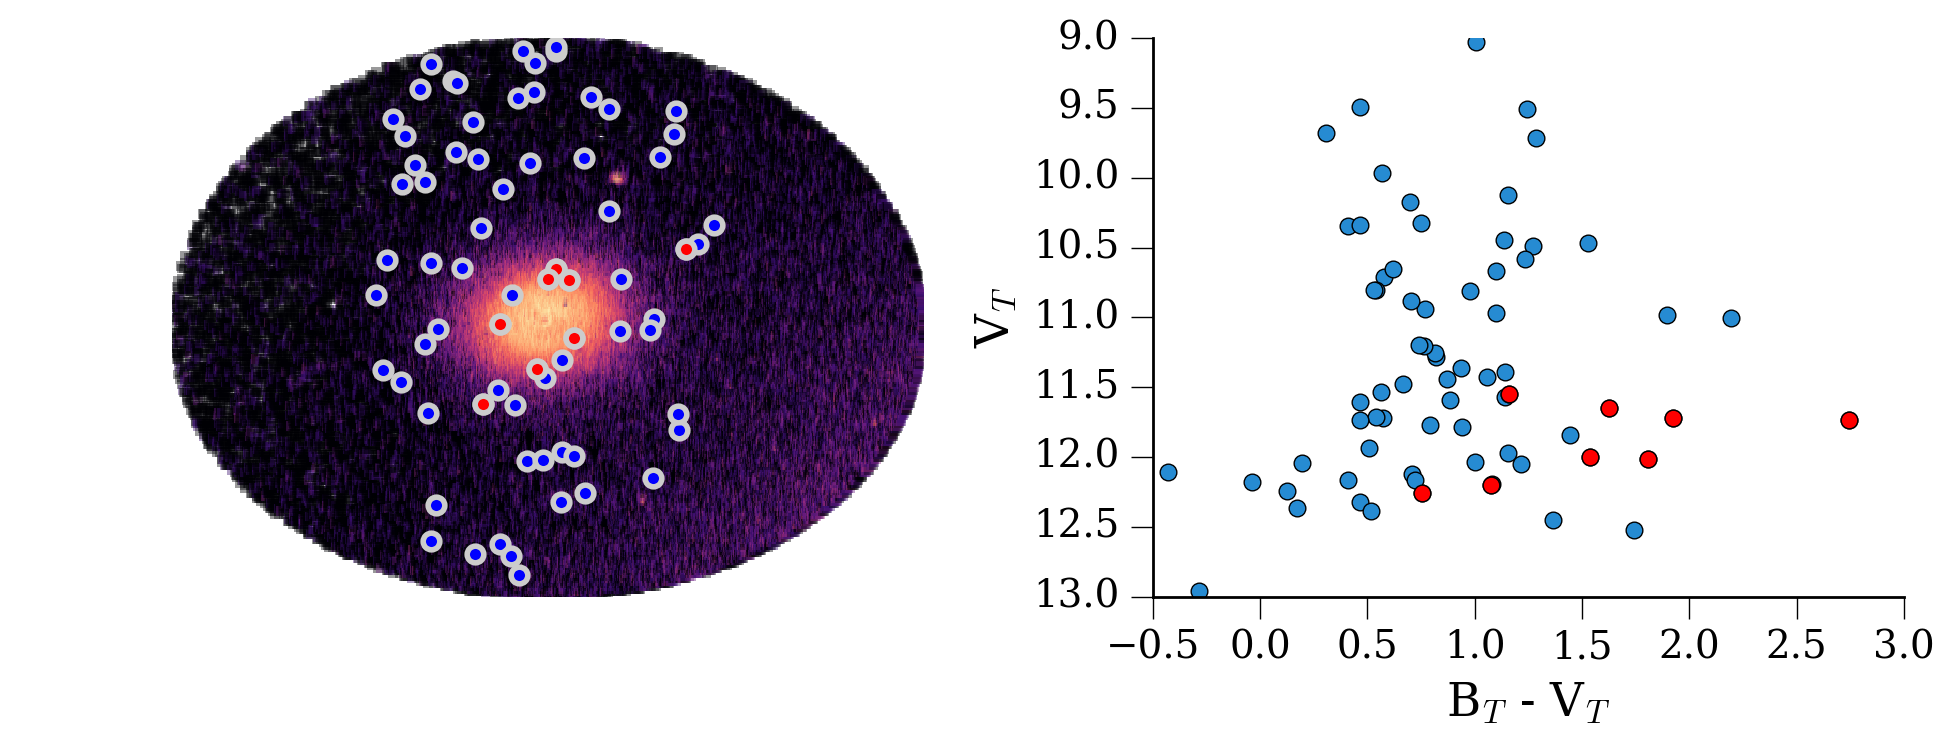

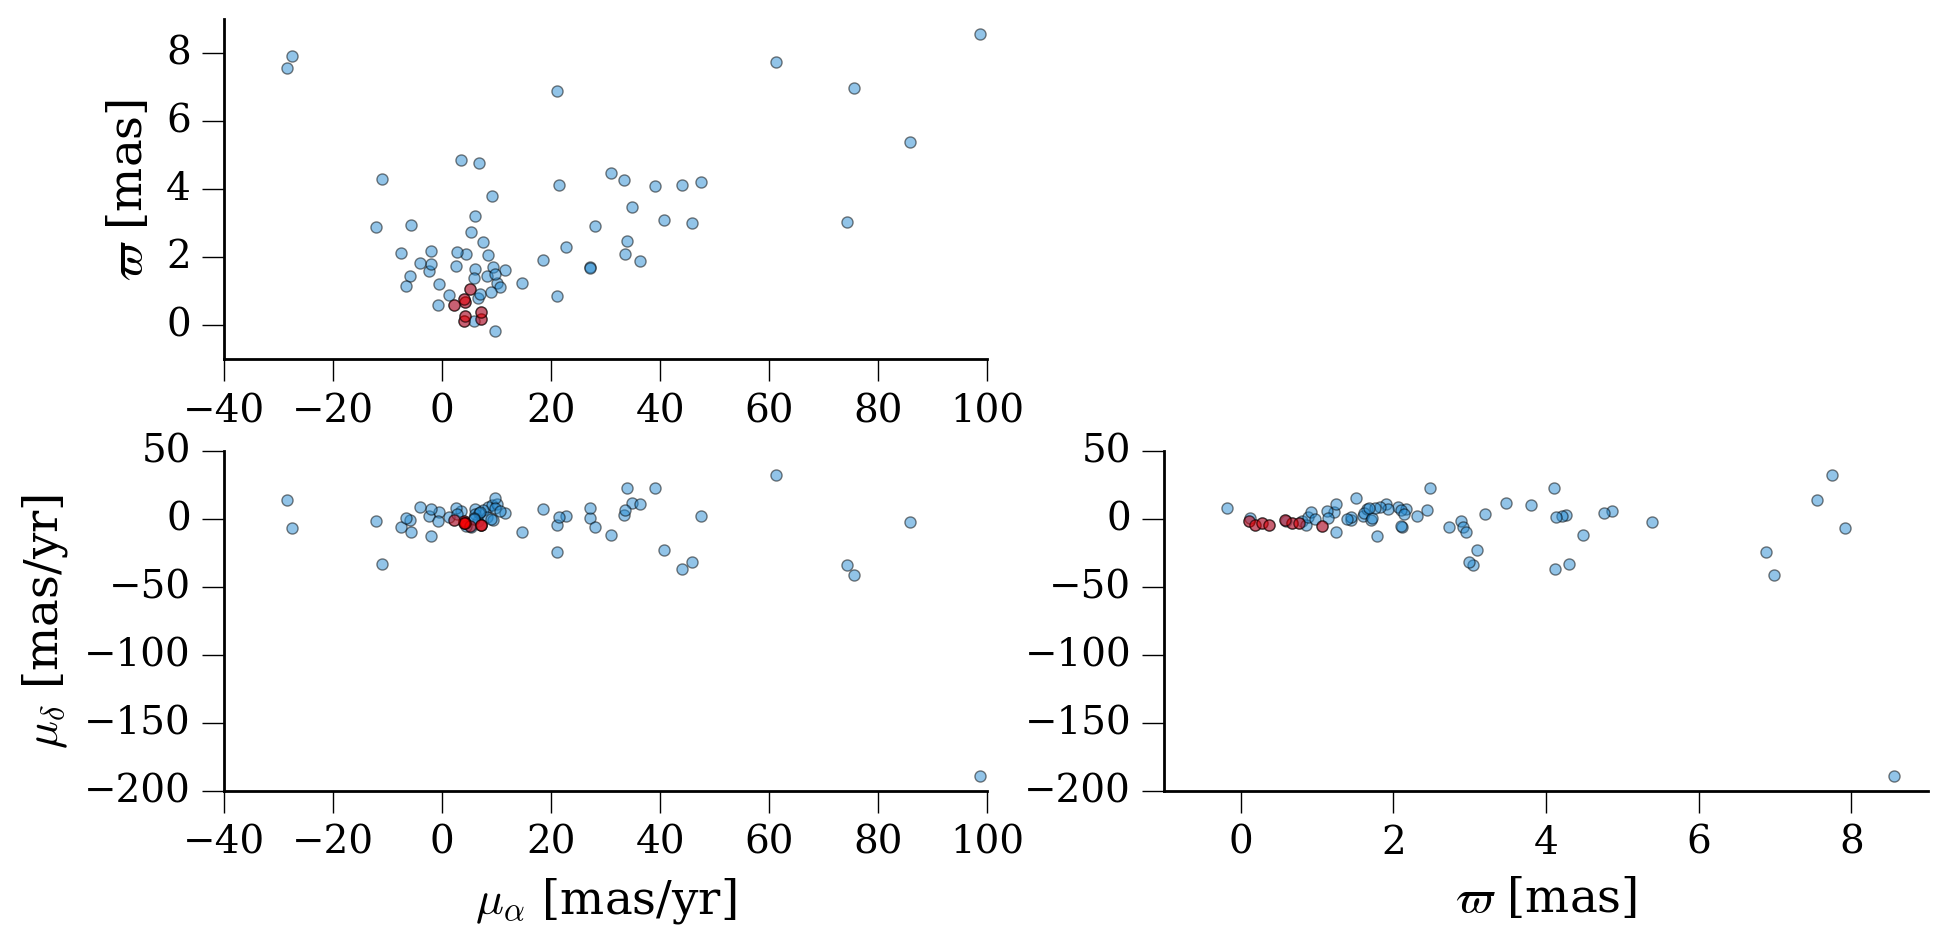

In [44]:
fig_plot(data, ngc104, members=members, ms=4, alpha=0.5)

**A little bit of crazy**

Below I added the calculations of the second likelihood directly in ADQL. As you can see, this is (i) tedious for a simple 3x3 matrix only, (ii) not readable. Of course it gives the same results.

This example is mostly to show that one can implement complex variables and if necessary embed one query into another for more complex calculations.

In [45]:
def get_tgas_stars_full(center_ra, center_dec, Rtidal, parallax, parallaxerr, 
                        mualpha, mualphaerr, mudelta, mudeltaerr, s_v):
    """ (sync)Query the database for a particular position and cluster properties. 
    
    Parameters
    ----------
    center_ra: float
        RA of the cluster center
    center_dec: float
        Dec of the cluster center
    Rtidal: float
        tidal radius of the cluster (in degrees)
    parallax: float
        mean parallax of the cluster in mas (1 mas <-> 1kpc)
    parallaxerr: float
        uncertainty on the cluster parallax
    mualpha: float
        mean proper motion of the cluster along RA (in mas/yr)
    mualphaerr: float
        mean proper motion uncertainty of the cluster along RA (in mas/yr)
    mudelta: float
        mean proper motion of the cluster along Dec (in mas/yr)
    mudeltaerr: float
        mean proper motion uncertainty of the cluster along Dec (in mas/yr)
    s_v: float
        internal velocity dispersion
    
    Returns
    -------
    data: Table
        entries from the query
    """
    adql = QueryStr("""
    select *, 
        q.a * (q.d * q.f - q.e * q.e) - q.b * (q.b * q.f - q.c * q.e) + q.c * q.e * (q.b - q.c) as det_pm_cov,
        -0.5 * (delta_parallax*(delta_parallax*(-(q.a*q.d - power(q.b, 2))*(-q.b*(q.e - q.b*q.c/q.a)/(q.a*(q.d - power(q.b, 2)/q.a)) + q.c/q.a)*(q.b*(q.e - q.b*q.c/q.a)/(q.a*(q.d - power(q.b, 2)/q.a)) - q.c/q.a)/(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d) + 1.0/q.a + power(q.b, 2)/(power(q.a, 2)*(q.d - power(q.b, 2)/q.a))) + delta_pmalpha*((q.e - q.b*q.c/q.a)*(q.a*q.d - power(q.b, 2))*(-q.b*(q.e - q.b*q.c/q.a)/(q.a*(q.d - power(q.b, 2)/q.a)) + q.c/q.a)/((q.d - power(q.b, 2)/q.a)*(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d)) - q.b/(q.a*(q.d - power(q.b, 2)/q.a))) - delta_pmdec*(q.a*q.d - power(q.b, 2))*(-q.b*(q.e - q.b*q.c/q.a)/(q.a*(q.d - power(q.b, 2)/q.a)) + q.c/q.a)/(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d)) + delta_pmalpha*(delta_parallax*(-(q.e - q.b*q.c/q.a)*(q.a*q.d - power(q.b, 2))*(q.b*(q.e - q.b*q.c/q.a)/(q.a*(q.d - power(q.b, 2)/q.a)) - q.c/q.a)/((q.d - power(q.b, 2)/q.a)*(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d)) - q.b/(q.a*(q.d - power(q.b, 2)/q.a))) + delta_pmalpha*(1.0/(q.d - power(q.b, 2)/q.a) + power(q.e - q.b*q.c/q.a, 2)*(q.a*q.d - power(q.b, 2))/(power(q.d - power(q.b, 2)/q.a, 2)*(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d))) - delta_pmdec*(q.e - q.b*q.c/q.a)*(q.a*q.d - power(q.b, 2))/((q.d - power(q.b, 2)/q.a)*(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d))) + delta_pmdec*(delta_parallax*(q.a*q.d - power(q.b, 2))*(q.b*(q.e - q.b*q.c/q.a)/(q.a*(q.d - power(q.b, 2)/q.a)) - q.c/q.a)/(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d) - delta_pmalpha*(q.e - q.b*q.c/q.a)*(q.a*q.d - power(q.b, 2))/((q.d - power(q.b, 2)/q.a)*(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d)) + delta_pmdec*(q.a*q.d - power(q.b, 2))/(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d))) as lnl_mu
    from (
        select 
            gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec,
            gaia.phot_g_mean_mag as G_mag, tycho2.bt_mag, tycho2.vt_mag, parallax_error,
            pmra_error, pmdec_error, pmra_pmdec_corr, parallax_pmra_corr, parallax_pmdec_corr,
            (-0.5 / power({Rtidal:f},2) * (power({center_ra:+f} - gaia.ra , 2) + power({center_dec:+f}-gaia.dec, 2))) as lnl_alpha_delta,
            power({s_gcparallax:f}, 2) + power(gaia.parallax_error, 2) as a,
            gaia.parallax_pmra_corr * gaia.parallax_error * gaia.pmra_error as b,
            gaia.parallax_pmdec_corr * gaia.parallax_error * gaia.pmdec_error as c,
            power({s_gcmualpha:f},2) + power({s_gcv:f}, 2) + power(gaia.pmra_error, 2) as d,
            gaia.pmra_pmdec_corr * gaia.pmra_error * gaia.pmdec_error as e,
            power({s_gcmudelta:f},2) + power({s_gcv:f}, 2) + power(gaia.pmdec_error, 2) as f,
            (gaia.parallax - {gc_parallax:f}) as delta_parallax,
            (gaia.pmra + (-1) * {gc_pmra:f}) as delta_pmalpha,
            (gaia.pmdec + (-1) * {gc_pmdec:f}) as delta_pmdec
        from 
            gaiadr1.tgas_source as gaia
        inner join 
            public.tycho2 as tycho2
            on gaia.tycho2_id = tycho2.id
        where 
            contains(point('ICRS', gaia.ra, gaia.dec),
                     circle('ICRS',{center_ra:f}, {center_dec:f}, {size:f}) )=1 
        ) as q
""".format(center_ra=center_ra, center_dec=center_dec, Rtidal=Rtidal, size=3 * Rtidal,
           gc_parallax=parallax, gc_pmra=mualpha, gc_pmdec=mudelta, 
           s_gcparallax=parallaxerr, s_gcmualpha=mualphaerr, s_gcmudelta=mudeltaerr, s_gcv=s_v
           ))
    gaia = GaiaArchive()
    return timeit(gaia.query)(adql)

In [46]:
# 1 milliarcsec = 1kpc
ra, dec, Rtidal, parallax, parallaxerr, mualpha, mualphaerr, mudelta, mudeltaerr, s_v = (
    6.02, -72.08, 0.360, 1. / 4.5, 0, 5.63,  0.21, -2.73, 0.29, 0.0
)
ngc104 = get_tgas_stars_full(ra, dec, Rtidal, parallax, parallaxerr, 
                             mualpha, mualphaerr, mudelta, mudeltaerr, 
                             s_v)

*ADQL query*
```mysql

    SELECT *,
        q.a * (q.d * q.f - q.e * q.e) - q.b * (q.b * q.f - q.c * q.e) + q.c * q.e * (q.b - q.c) AS det_pm_cov,
        -0.5 * (delta_parallax*(delta_parallax*(-(q.a*q.d - power(q.b, 2))*(-q.b*(q.e - q.b*q.c/q.a)/(q.a*(q.d - power(q.b, 2)/q.a)) + q.c/q.a)*(q.b*(q.e - q.b*q.c/q.a)/(q.a*(q.d - power(q.b, 2)/q.a)) - q.c/q.a)/(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d) + 1.0/q.a + power(q.b, 2)/(power(q.a, 2)*(q.d - power(q.b, 2)/q.a))) + delta_pmalpha*((q.e - q.b*q.c/q.a)*(q.a*q.d - power(q.b, 2))*(-q.b*(q.e - q.b*q.c/q.a)/(q.a*(q.d - power(q.b, 2)/q.a)) + q.c/q.a)/((q.d - power(q.b, 2)/q.a)*(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d)) - q.b/(q.a*(q.d - power(q.b, 2)/q.a))) - delta_pmdec*(q.a*q.d - power(q.b, 2))*(-q.b*(q.e - q.b*q.c/q.a)/(q.a*(q.d - power(q.b, 2)/q.a)) + q.c/q.a)/(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d)) + delta_pmalpha*(delta_parallax*(-(q.e - q.b*q.c/q.a)*(q.a*q.d - power(q.b, 2))*(q.b*(q.e - q.b*q.c/q.a)/(q.a*(q.d - power(q.b, 2)/q.a)) - q.c/q.a)/((q.d - power(q.b, 2)/q.a)*(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d)) - q.b/(q.a*(q.d - power(q.b, 2)/q.a))) + delta_pmalpha*(1.0/(q.d - power(q.b, 2)/q.a) + power(q.e - q.b*q.c/q.a, 2)*(q.a*q.d - power(q.b, 2))/(power(q.d - power(q.b, 2)/q.a, 2)*(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d))) - delta_pmdec*(q.e - q.b*q.c/q.a)*(q.a*q.d - power(q.b, 2))/((q.d - power(q.b, 2)/q.a)*(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d))) + delta_pmdec*(delta_parallax*(q.a*q.d - power(q.b, 2))*(q.b*(q.e - q.b*q.c/q.a)/(q.a*(q.d - power(q.b, 2)/q.a)) - q.c/q.a)/(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d) - delta_pmalpha*(q.e - q.b*q.c/q.a)*(q.a*q.d - power(q.b, 2))/((q.d - power(q.b, 2)/q.a)*(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d)) + delta_pmdec*(q.a*q.d - power(q.b, 2))/(q.a*q.d*q.f - q.a*power(q.e, 2) - power(q.b, 2)*q.f + 2*q.b*q.c*q.e - power(q.c, 2)*q.d))) AS lnl_mu
    FROM (
        SELECT
            gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec,
            gaia.phot_g_mean_mag AS G_mag, tycho2.bt_mag, tycho2.vt_mag, parallax_error,
            pmra_error, pmdec_error, pmra_pmdec_corr, parallax_pmra_corr, parallax_pmdec_corr,
            (-0.5 / power(0.360000,2) * (power(+6.020000 - gaia.ra , 2) + power(-72.080000-gaia.dec, 2))) AS lnl_alpha_delta,
            power(0.000000, 2) + power(gaia.parallax_error, 2) AS a,
            gaia.parallax_pmra_corr * gaia.parallax_error * gaia.pmra_error AS b,
            gaia.parallax_pmdec_corr * gaia.parallax_error * gaia.pmdec_error AS c,
            power(0.210000,2) + power(0.000000, 2) + power(gaia.pmra_error, 2) AS d,
            gaia.pmra_pmdec_corr * gaia.pmra_error * gaia.pmdec_error AS e,
            power(0.290000,2) + power(0.000000, 2) + power(gaia.pmdec_error, 2) AS f,
            (gaia.parallax - 0.222222) AS delta_parallax,
            (gaia.pmra + (-1) * 5.630000) AS delta_pmalpha,
            (gaia.pmdec + (-1) * -2.730000) AS delta_pmdec
        FROM
            gaiadr1.tgas_source AS gaia
        INNER JOIN
            public.tycho2 AS tycho2
            ON gaia.tycho2_id = tycho2.id
        WHERE
            contains(point('ICRS', gaia.ra, gaia.dec),
                     circle('ICRS',6.020000, -72.080000, 1.080000) )=1
        ) AS q

```

*Execution time*: 397 ms

In [49]:
lnl = (- 0.5 * np.log(abs(ngc104['det_pm_cov'])) + ngc104['lnl_mu'] + ngc104['lnl_alpha_delta'])
from astropy.table import Column
ngc104.add_column(Column(lnl, name='lnl'))
fields = ['source_id', 'ra', 'dec', 'parallax', 'lnl_alpha_delta', 'lnl_mu', 'lnl']
members = result[result['lnl'] > -11]
members.sort('lnl')
members[fields][::-1]

source_id,ra,dec,parallax,lnl_alpha_delta,lnl_mu,lnl
,Angle[deg],Angle[deg],Angle[mas],,,
int64,float64,float64,float64,float64,float64,float64
4689644416501132800,6.2170101137593949,-71.936456942381554,0.37507341579041814,-0.22923454596428225,-2.7988054087,-3.02803995467
4689638437899435136,5.5745638831857649,-72.103433200803295,0.58021017218719462,-0.76760204113592645,-4.52626678339,-5.29386882452
4689645000616682240,6.0141150444826863,-71.929822389578547,0.7569972004848331,-0.087144858693433566,-5.61636849493,-5.70351335362
4689620330317403136,5.9132796741373417,-72.277756673829472,0.27418891704465148,-0.19481840276361445,-5.85211566785,-6.04693407061
4689832845301844352,6.0936958914206301,-71.891298383615776,1.0583841942748684,-0.15833095848109333,-6.13607645112,-6.2944074096
4689623594492482176,6.2653565131119864,-72.15881251500781,0.18046400711992883,-0.25621616916793633,-6.19642464456,-6.45264081373
4689595831823970304,5.4133921110160106,-72.414062612237686,0.67526452113793323,-1.8501966044470644,-4.82298628575,-6.6731828902
4690024022888359424,7.304409361221766,-71.815410192959902,0.1092560087723143,-6.6347036002454525,-3.9692286786,-10.6039322788


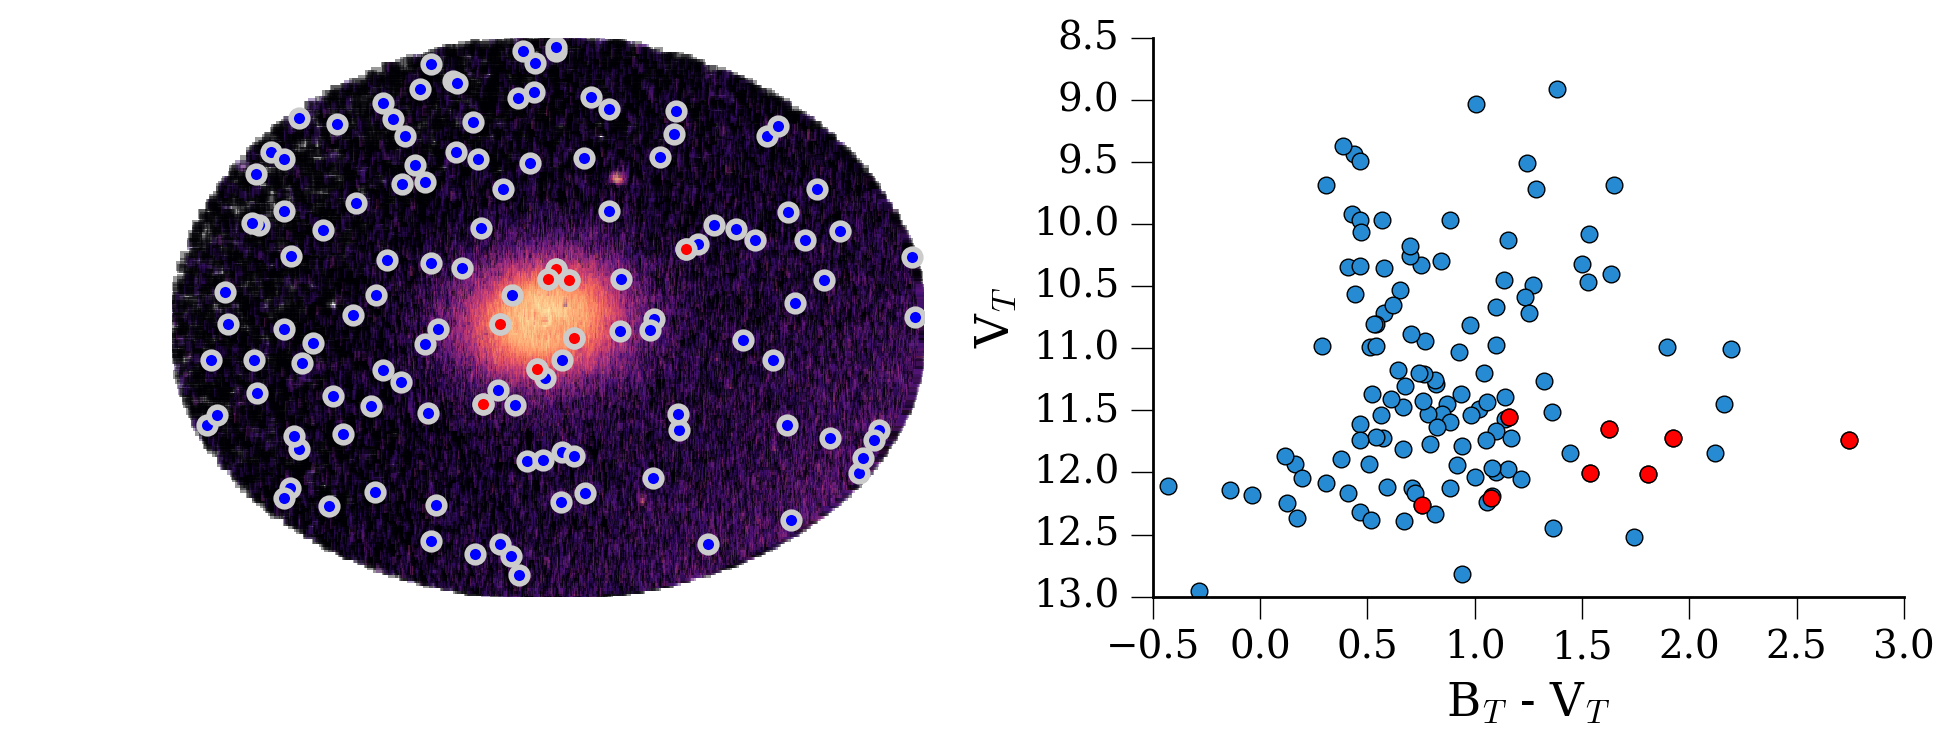

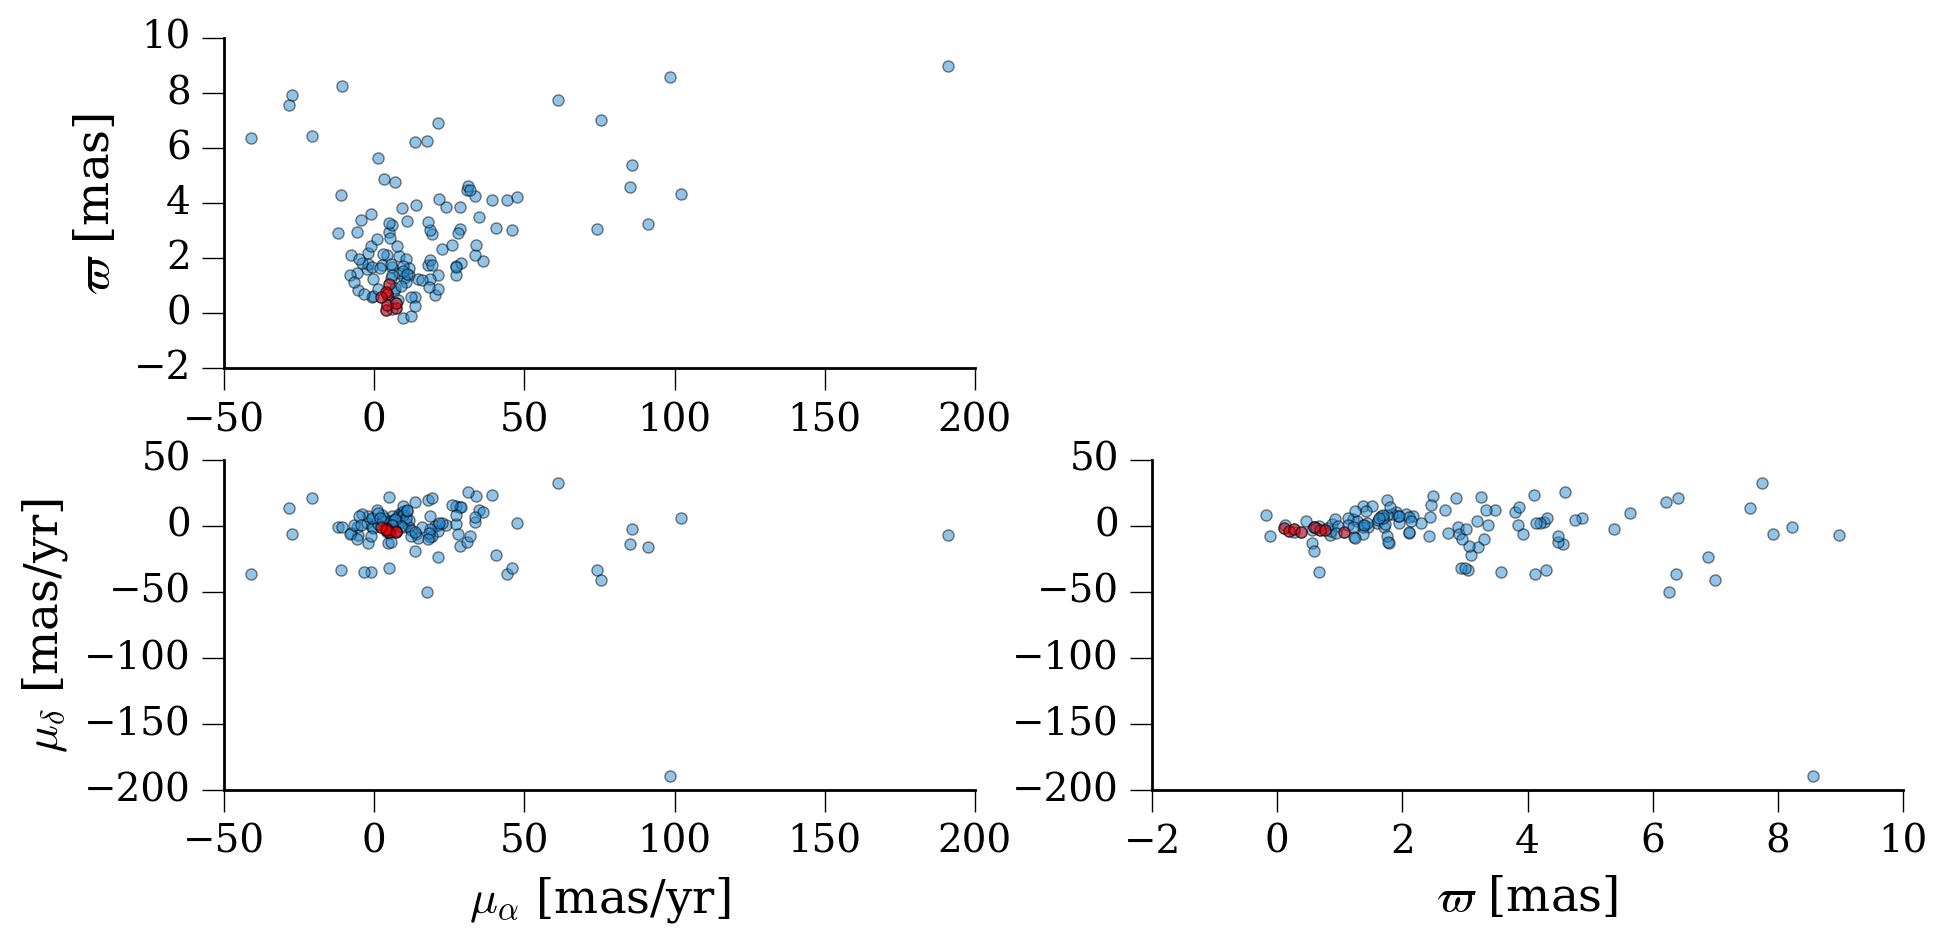

In [50]:
fig_plot(data, ngc104, members=members, ms=4, alpha=0.5)

**Some comment for the authors of Watkins et al.**

* The position likelihood is incorrect. It should be a sherical distance not a cartesian one. This gives more weight on RA than DEC variations.
* differences are most likely on my side, **I do not use $\sigma_v$, $\sigma_r$**, but I am puzzled. The missing stars are not close to the threshold.